<a href="https://colab.research.google.com/github/sotudian/BL_Exp/blob/main/Second_Project_GEP_Ranking_Prostate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [184]:
pip install pyreadr gseapy

In [221]:
! apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [224]:
!git clone https://github.com/sotudian/Baca_Lab_Exp.git

Cloning into 'Baca_Lab_Exp'...
fatal: could not read Username for 'https://github.com': No such device or address


In [185]:
import numpy as np
import pandas as pd
import pyreadr
import random
from sklearn import preprocessing
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import os
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.metrics import classification_report,f1_score, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold,cross_val_score, KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
import lightgbm as lgb
#from scipy import stats
import statsmodels.api as sm
# import pylab as pl
import json
import copy
import pickle
from sklearn.decomposition import PCA
import jax
import jax.numpy as jnp
import torch
from IPython.display import display, HTML
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import ndcg_score, average_precision_score
from scipy.stats import spearmanr, kendalltau


In [186]:
Naive_cols = ['FC_Small21','FC_Small22','FC_Small23', 'FC_Small24','FC_Small25','FC_Small26','FC_Small27','FC_Small28','FC_Small29','FC_Small30']


OP = {
          "Model_type" : "Rank_ndcg",  #  Rank_map    Rank_ndcg
          "Save_training_flag": False,
          "Name_Save_load_Data":"Name_will_be_completed_line19",
          "Drive_Dir":"/content/drive/MyDrive/Second_Project_GeneExpression_Prediction/",
          "Save_Folder_Name": 'Ranking_Result_',
          "Main_Dir": '/content/'
          }

OP["Name_Save_load_Data"] = "ML_"+OP["Model_type"]+"_GEP_"

OP["Save_Folder_Name"] = OP["Save_Folder_Name"]+OP["Model_type"]

In [187]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [188]:
# Functions


def Train_Func(X_train,Y_Train,clf,Model_type,Qid):
      if OP["Model_type"] == "Rank_map":
          clf.fit(X_train,Y_Train, qid=Qid)
      elif OP["Model_type"] == "Rank_ndcg":
          clf.fit(X_train,Y_Train, qid=Qid)
      return clf





def Ranking_Evaluation(GT_labels,Pred_scores,GT_Rank,Pred_Rank):
    #GT_labels =   TMP_Df['GT']
    #Pred_scores = TMP_Df['My_Pred']    OR    TMP_Df['Naive_Pred']
    #GT_Rank = TMP_Df['GT_Rank']
    #Pred_Rank = TMP_Df['My_Pred_Rank']   or   TMP_Df['Naive_Rank']
    Eval_Dic = {}
    Eval_Dic['NDCG'] = ndcg_score(np.asarray([GT_labels]).astype(int)   , np.asarray([Pred_scores]) )
    Eval_Dic['NDCG@10'] = ndcg_score(np.asarray([GT_labels]).astype(int)   , np.asarray([Pred_scores]) , k =10)
    Eval_Dic['NDCG@25'] = ndcg_score(np.asarray([GT_labels]).astype(int)   , np.asarray([Pred_scores]) , k =25)
    Eval_Dic['NDCG@50'] = ndcg_score(np.asarray([GT_labels]).astype(int)   , np.asarray([Pred_scores]) , k =50)
    Eval_Dic['NDCG@100'] = ndcg_score(np.asarray([GT_labels]).astype(int)   , np.asarray([Pred_scores]) , k =100)

    Eval_Dic['AH@10'] = sum(Pred_Rank.head(10) <= 10)
    Eval_Dic['AH@25'] = sum(Pred_Rank.head(25) <= 25)
    Eval_Dic['AH@50'] = sum(Pred_Rank.head(50) <= 50)

    Eval_Dic['Spearman'] = spearmanr(GT_Rank, Pred_Rank).correlation
    Eval_Dic['Spearman@25'] = spearmanr(GT_Rank[:25], Pred_Rank[:25]).correlation
    Eval_Dic['Spearman@100'] = spearmanr(GT_Rank[:100], Pred_Rank[:100]).correlation

    Eval_Dic['KendallTau'] = kendalltau(GT_Rank, Pred_Rank).correlation
    Eval_Dic['KendallTau@25'] = kendalltau(GT_Rank[:25], Pred_Rank[:25]).correlation
    Eval_Dic['KendallTau@100'] = kendalltau(GT_Rank[:100], Pred_Rank[:100]).correlation



    return Eval_Dic



def Test_Eval_Func(DF_Test,clf,Model_type,Naive_cols):
    predictions_dict = {}
    Perf_Rankning_scores = {}
    Perf_Rankning_scores['Num_samples'] = 0
    Perf_Naive_scores = {}
    Perf_Naive_scores['Num_samples'] = 0
    # add random value - duplicates
    np.random.seed(2023)

    Random_Val_Added = np.random.uniform(0, 0.000001, size=DF_Test[DF_Test["Qid"] == pd.unique(DF_Test["Qid"])[1]].shape[0])
    for id in pd.unique(DF_Test["Qid"]):
              xtest = DF_Test[DF_Test["Qid"] == id].drop(['Label',"Qid","Gene_name","Label_GE"], axis=1)
              ytest = DF_Test[DF_Test["Qid"] == id].loc[:,'Label']
              Actual_Gene_Exp_Label = DF_Test[DF_Test["Qid"] == id].loc[:,'Label_GE']


              ytest_pred_score = clf.predict(xtest.values)
              y_pred_Naive = np.sum(xtest[Naive_cols], axis=1)

              # add random value - duplicates
              ytest_pred_score = ytest_pred_score + Random_Val_Added
              y_pred_Naive = y_pred_Naive + Random_Val_Added
              Actual_Gene_Exp_Label = Actual_Gene_Exp_Label + Random_Val_Added
              ytest = ytest + Random_Val_Added

              M_GT_Rank = Actual_Gene_Exp_Label.rank(ascending=False,method='first')
              M_My_Pred_Rank = list(pd.DataFrame(ytest_pred_score.tolist()).rank(ascending=False,method='first').loc[:,0])
              M_Naive_Pred = y_pred_Naive.tolist()
              M_Naive_Rank = list(pd.DataFrame(y_pred_Naive.tolist()).rank(ascending=False,method='first').loc[:,0])

              TMP_Df = pd.DataFrame({ 'Gene':list(DF_Test[DF_Test["Qid"] == id].loc[:,'Gene_name']),
                                      'Gene_Exp_Label':list(Actual_Gene_Exp_Label),
                                      'GT': ytest,
                                      'GT_Rank': M_GT_Rank,
                                      'My_Pred': ytest_pred_score,
                                      'My_Pred_Rank': M_My_Pred_Rank,
                                      'Naive_Pred': M_Naive_Pred,
                                      'Naive_Rank': M_Naive_Rank,
                                      })

              TMP_Df = TMP_Df.sort_values('Gene_Exp_Label',ascending = False)






              predictions_dict[id] = TMP_Df
              print(f'\n######## Qid {id} - sample: {QID_Dic[id]}  - Results:\n')
              Perf_Ranking = Ranking_Evaluation(TMP_Df['GT'], TMP_Df['My_Pred'],TMP_Df['GT_Rank'], TMP_Df['My_Pred_Rank'])
              print('OOO Ranking model =====>      ' +"   ||   ".join([x+" = "+str(round(Perf_Ranking[x],3)) for x in Perf_Ranking])+   ' \n')


              Perf_Naive = Ranking_Evaluation(TMP_Df['GT'], TMP_Df['Naive_Pred'],TMP_Df['GT_Rank'], TMP_Df['Naive_Rank'])
              print('OOO Naive model =====>      ' +"   ||   ".join([x+" = "+str(round(Perf_Naive[x],3)) for x in Perf_Naive])+   ' \n')
              for k in Perf_Ranking:
                  if k in Perf_Rankning_scores:
                      Perf_Rankning_scores[k] += Perf_Ranking[k]
                      Perf_Naive_scores[k] += Perf_Naive[k]
                  else:
                      Perf_Rankning_scores[k] = Perf_Ranking[k]
                      Perf_Naive_scores[k] = Perf_Naive[k]
              Perf_Rankning_scores['Num_samples'] += 1
              Perf_Naive_scores['Num_samples'] += 1

    print('\n################################\n### Average of All Qids :\n################################')
    print('OOO Averge Performance Ranking model =====>      ' +"   ||   ".join(["Average "+x+" = "+str(round(Perf_Rankning_scores[x]/Perf_Rankning_scores['Num_samples'],3)) for x in Perf_Rankning_scores if x !='Num_samples'])+   ' \n')
    print('OOO Averge Performance Naive model   =====>      ' +"   ||   ".join(["Average "+x+" = "+str(round(Perf_Naive_scores[x]/Perf_Naive_scores['Num_samples'],3)) for x in Perf_Naive_scores if x !='Num_samples'])+   ' \n')
    predictions_dict['Perf_Rankning_scores'] = Perf_Rankning_scores
    predictions_dict['Perf_Naive_scores'] = Perf_Naive_scores
    return predictions_dict




def PreProcessing_Steps(Raw_Data,Except_col):
      labels = list(Raw_Data['Label'])
      QIDs = list(Raw_Data[Except_col[0]])
      Gene_name = list(Raw_Data[Except_col[1]])
      Raw_Data = Raw_Data.drop(['Label',Except_col[0],Except_col[1]], axis=1)
      # Normalize Continious features
      scaler = preprocessing.StandardScaler()
      columns_to_normalize = Raw_Data.columns
      Raw_Data[columns_to_normalize] = scaler.fit_transform(Raw_Data[columns_to_normalize])
      del scaler,columns_to_normalize
      Raw_Data = Raw_Data.assign(Label=labels)
      Raw_Data = Raw_Data.assign(Qid=QIDs)
      Raw_Data = Raw_Data.assign(Gene_name=Gene_name)
      #Raw_Data['Label'] = labels
      # Fill NAs
      Raw_Data.fillna(Raw_Data.median(numeric_only= True), inplace=True)
      Raw_Data = Raw_Data.reset_index(drop=True)
      return Raw_Data




def LABELING_Method(Raw_Data,Method):
    if Method == 'binary':
          threshold = Raw_Data['Label'].quantile(0.90)
          Raw_Data['Label'] = (Raw_Data['Label'] >= threshold).astype(int)
    elif Method == '6_labels':
          AA = Raw_Data['Label']
          T1 = AA.quantile(0.75)
          T2 = AA.quantile(0.80)
          T3 = AA.quantile(0.85)
          T4 = AA.quantile(0.90)
          T5 = AA.quantile(0.95)
          labels = [0, 1, 2, 3, 4, 5]
          AA = pd.cut(AA, bins=[-float('inf'), T1, T2, T3, T4, T5, float('inf')], labels=labels)
          Raw_Data['Label'] = AA
    elif Method == '3_labels':
          AA = Raw_Data['Label']
          T1 = AA.quantile(0.90)
          T2 = AA.quantile(0.95)
          labels = [0, 1, 2]
          AA = pd.cut(AA, bins=[-float('inf'), T1, T2, float('inf')], labels=labels)
          Raw_Data['Label'] = AA
    elif Method == 'scores':
          AA = Raw_Data['Label']
          Raw_Data['Label'] = round(AA)
    return Raw_Data






def PLOTTING(All_Performnace_Matrix_DF):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # Plot the first subplot on the left side
    axes[0].plot(All_Performnace_Matrix_DF["Number_of_Training_Samples"], All_Performnace_Matrix_DF["F1_SCORE"], label="F1_SCORE")
    axes[0].set_xlabel("Number of Training Samples")
    axes[0].set_ylabel("F1 Score")
    axes[0].legend()

    # Plot the second subplot on the right side
    axes[1].plot(All_Performnace_Matrix_DF["Number_of_Training_Samples"], All_Performnace_Matrix_DF["AUC"], label="AUC", color='green')
    axes[1].set_xlabel("Number of Training Samples")
    axes[1].set_ylabel("AUC")
    axes[1].legend()

    # Display the figure with both subplots
    plt.tight_layout()
    plt.show()





def Feature_Importance_Plots(ML_Model,Model_type,Feature_Types):
      feature_names = ML_Model.feature_names_in_.tolist()
      feature_importance = (ML_Model.feature_importances_).tolist()
      total_subplots = len(Feature_Types)
      fig, axes = plt.subplots(total_subplots, 1, figsize=(6, 8 * total_subplots))


      for j in range(total_subplots):

          indices = [i for i, element in enumerate(feature_names) if element.startswith(Feature_Types[j])]
          features_to_plot = [feature_names[s] for s in indices]
          scores_to_plot = [feature_importance[s] for s in indices]

          ax = axes[j]
          ax.barh(features_to_plot, scores_to_plot,color='red')
          ax.set_xlabel(OP["Model_type"]+'-Model Feature Importance')
          ax.set_ylabel('Features')
          ax.set_title(OP["Model_type"]+f'-Feature Importance - Features {Feature_Types[j]}')
          ax.set_xlim([min(feature_importance), max(feature_importance)])
          ax.set_yticklabels(features_to_plot, fontsize=7)  # You can adjust the fontsize as needed

      plt.tight_layout()  # Ensure proper spacing between subplots
      plt.show()



# **--- Load Raw Data ---------------------**

In [189]:
removed_cols = ['Gene_id','chr','start','end','TSS_s_samll','TSS_e_samll']
Cancer_Types = ['Prostate', 'Healthy']    #  'Breast','Prostate','NSCLC','Colorectal'  'Healthy
folder_name = 'Final_Data_All_Cancer_Types/'  #'Data_'+'_'.join(Cancer_Types)+'/'
Fig_cancerType = "Prostate"
Test_study_names = ["K4_TRC25_1", "K4_NEPC16", "K4_HPC81_1","HP024788","HP28203Me3R1"]
prefixes_to_drop = ["FL_median_", "GC_Small"]
Sample_error_remove = ["Final_DATA_GEP_Num_213_study_name_K4_TRC61_2_individual_id_TRC-PL-0061-002_cancer_type_Prostate_WL_10000_NBins_50_.rds",
                       "Final_DATA_GEP_Num_205_study_name_K4me3_TRC1_individual_id_TRC-PL-0007-001_cancer_type_Prostate_WL_10000_NBins_50_.rds",
                       "Final_DATA_GEP_Num_118_study_name_NEPC8K4R2_individual_id_NEPCmlf008_cancer_type_Prostate_WL_10000_NBins_50_.rds"]

print("Load and Process the raw Data ......")
Dir_Add = OP["Drive_Dir"]+'Data/'+folder_name
Data_list = os.listdir(OP["Drive_Dir"]+'Data/'+folder_name)
Data_list = [file for file in Data_list if file.endswith('.rds')]
Data_list = [element for element in Data_list if element.split('_cancer_type_')[1].split('_WL_')[0] in Cancer_Types]

if len(Sample_error_remove)>0:
    for i in Sample_error_remove:
      Data_list.remove(i)



Excell_sampels = pd.read_excel(OP["Drive_Dir"]+'Data/Table_S1_with_file_locations.xlsx').drop(columns=['peak_number', 'antibody_vendor', 'source', 'enrichment', 'fragments', 'bam_file', 'rds_file','peak_file', 'bigwig_file', 'fastq1', 'fastq2'])
Excell_sampels= Excell_sampels[Excell_sampels['antibody'] == 'H3K4me3']
Excell_sampels= Excell_sampels[Excell_sampels['cancer_type'].isin(["Breast","Prostate","NSCLC","Colorectal","Healthy"])]
Excell_sampels = Excell_sampels.drop_duplicates(subset='individual_id', keep='first')

Selcted_samples_DF =(Excell_sampels[Excell_sampels['study_name'].isin( [element.split('_study_name_')[1].split('_individual_id_')[0] for element in Data_list])])
print("Number of samples Excell file: ",len((Selcted_samples_DF))," VS Number of samples Data_list: ",len(Data_list))
display(HTML(Selcted_samples_DF.to_html()))

# Test Samples
test_samples = [element for element in Data_list if element.split('_study_name_')[1].split('_individual_id_')[0] in Test_study_names]




Load and Process the raw Data ......
Number of samples Excell file:  79  VS Number of samples Data_list:  99


,study_name,antibody,sample_id,ctDNA,individual_id,cancer_type,cancer_subtype,HER2
4,advPC_20_JS8584_S124,H3K4me3,PCmlf0020,NaN,PCmlf0020,Prostate,PRAD,NaN
5,advPC_3_JS8584_S121,H3K4me3,PCmlf0003,NaN,PCmlf0003,Prostate,PRAD,NaN
6,PRAD3260_JS8584_S130,H3K4me3,GENP3260-1,NaN,GENP3260-1,Prostate,PRAD,NaN
13,advPC_13_JS8585_S72,H3K4me3,PCmlf0013,NaN,PCmlf0013,Prostate,PRAD,NaN
16,advPC_21_JS8585_S75,H3K4me3,PCmlf0021,NaN,PCmlf0021,Prostate,PRAD,NaN
18,advPC_9_JS8585_S71,H3K4me3,PCmlf0009,NaN,PCmlf0009,Prostate,PRAD,NaN
26,DgMe3_metPC_24_JS8753_S88,H3K4me3,PCmlf0024,NaN,PCmlf0024,Prostate,PRAD,NaN
27,DgMe3_metPC_26_JS8753_S89,H3K4me3,PCmlf0026,NaN,PCmlf0026,Prostate,PRAD,NaN
28,DgMe3_metPC_28_JS8753_S91,H3K4me3,PCmlf0028,0.10320,PCmlf0028,Prostate,PRAD,NaN
29,DgMe3_metPC_29_JS8753_S92,H3K4me3,PCmlf0029,NaN,PCmlf0029,Prostate,PRAD,NaN


In [190]:
Gene_Df = pyreadr.read_r(OP["Drive_Dir"]+'Data/Final_Data_Dseq2_Selected_GeneExp_Labels_eachCancer_vs_Healthy.Rda')['Final_df']
Gene_Df.head()

,gene_id_no_version,gene_name,chr,start,end,strand,Average_NSCLC_GE_fpkm,Average_Prostate_GE_fpkm,Average_Breast_GE_fpkm,Average_Colorectal_GE_fpkm,Average_Healthy_GE_fpkm,log2FoldChange_Breast,log2FoldChange_Prostate,log2FoldChange_NSCLC_LUAD,log2FoldChange_NSCLC_LUSC,log2FoldChange_Colorectal
0,ENSG00000000003,TSPAN6,chrX,99883667,99894988,-,3.769920,3.883328,3.432002,4.924239,0.140878,-6.737871,7.105322,7.354538,7.008714,-8.420489
1,ENSG00000000005,TNMD,chrX,99839799,99854882,+,0.071331,0.221774,0.593602,0.672837,0.009565,-6.566004,4.129553,2.603017,-0.326386,-5.971536
2,ENSG00000000938,FGR,chr1,27938575,27961788,-,2.702670,1.250374,1.769955,1.504501,7.793554,7.774949,-8.727854,-6.164482,-6.477772,8.126880
3,ENSG00000000971,CFH,chr1,196621008,196716634,+,3.380113,1.797127,2.743534,1.821406,0.518553,-3.903450,2.461862,4.785360,4.329484,-2.573728
4,ENSG00000001036,FUCA2,chr6,143815948,143832827,-,4.608675,4.547079,4.480851,5.063994,2.889887,-0.953684,0.982518,1.248593,0.964327,-1.521389


In [191]:
#Gene_Df[Gene_Df['gene_name'] ==""]

In [192]:

train_dataframes = []
test_dataframes = []
print("Total samples count: ",len(Data_list))
for ct in Cancer_Types:
  print(ct," cancer - count: ",len([element for element in Data_list if ct in element]))


train_samples = [element for element in Data_list if element not in test_samples]

count = 1
QID_Dic = {}
for file_name in Data_list:
            print(file_name)
            Data_raw = pyreadr.read_r(OP["Drive_Dir"]+'Data/'+folder_name+file_name)[None]
            Data_raw = Data_raw.drop(removed_cols, axis=1)
            # Filter columns that start with prefixes in the list
            columns_to_drop = [col for col in Data_raw.columns if any(col.startswith(prefix) for prefix in prefixes_to_drop)]
            Data_raw.drop(columns=columns_to_drop, inplace=True)

            Data_raw = Data_raw.rename(columns={'Label_GE_fpkm': 'Label'})
            Data_raw['Qid'] = [count] * len(Data_raw)
            QID_Dic[count] = file_name.split('_study_name_')[1].split('_individual_id')[0]+"_"+[ct for ct in Cancer_Types if ct in file_name ][0]

            print("Number of NAs: ",str(Data_raw.isna().sum().sum()))
            print("Impute missing values with the median of the corresponding column....")
            Data_raw = Data_raw.fillna(Data_raw.median(numeric_only=True))
            count += 1
            if file_name in train_samples:
                train_dataframes.append(Data_raw)
            else:
                test_dataframes.append(Data_raw)







Total samples count:  99
Prostate  cancer - count:  61
Healthy  cancer - count:  38
Final_DATA_GEP_Num_10_study_name_HP31645Me3R1_individual_id_10031645_cancer_type_Healthy_WL_10000_NBins_50_.rds
Number of NAs:  1868
Impute missing values with the median of the corresponding column....
Final_DATA_GEP_Num_9_study_name_HP030912_individual_id_10030912_cancer_type_Healthy_WL_10000_NBins_50_.rds
Number of NAs:  1143
Impute missing values with the median of the corresponding column....
Final_DATA_GEP_Num_8_study_name_HP030642_individual_id_10030642_cancer_type_Healthy_WL_10000_NBins_50_.rds
Number of NAs:  1133
Impute missing values with the median of the corresponding column....
Final_DATA_GEP_Num_7_study_name_HP030132_individual_id_10030132_cancer_type_Healthy_WL_10000_NBins_50_.rds
Number of NAs:  988
Impute missing values with the median of the corresponding column....
Final_DATA_GEP_Num_6_study_name_HP029376_individual_id_10029376_cancer_type_Healthy_WL_10000_NBins_50_.rds
Number of NAs

In [193]:

Method_Labeling = "scores"    #  '3_labels'  "6_labels"    "binary"    "scores"

Raw_Train_Data = pd.concat(train_dataframes, ignore_index=True)
Raw_Train_Data = Raw_Train_Data.reset_index(drop=True)
Raw_Train_Data = PreProcessing_Steps(Raw_Train_Data,["Qid",'Gene_name']) # PreProcessing_Steps
Label_continuous_TRAIN  = list(Raw_Train_Data['Label'])
Raw_Train_Data = Raw_Train_Data.assign(Label_GE= list(Raw_Train_Data['Label']) )
Raw_Train_Data =  LABELING_Method(Raw_Train_Data,Method_Labeling)   #  '3_labels'  "6_labels"    "binary"


Raw_Test_Data = pd.concat(test_dataframes, ignore_index=True)
Raw_Test_Data = Raw_Test_Data.reset_index(drop=True)
Raw_Test_Data = PreProcessing_Steps(Raw_Test_Data,["Qid",'Gene_name']) # PreProcessing_Steps
Raw_Test_Data = Raw_Test_Data.assign(Label_GE= list(Raw_Test_Data['Label']) )
Raw_Test_Data =  LABELING_Method(Raw_Test_Data,Method_Labeling)   #  '3_labels'  "6_labels"    "binary"


print("Number of Training samples: ",len(Raw_Train_Data))
print("Number of Test samples: ",len(Raw_Test_Data))
display(HTML(Raw_Test_Data.head(10).to_html()))


Number of Training samples:  1115686
Number of Test samples:  59345


,FLC_P5,FLC_P25,FLC_P50,FLC_P75,FLC_P95,GC_Skew_Small1,GC_Skew_Small2,GC_Skew_Small3,GC_Skew_Small4,GC_Skew_Small5,GC_Skew_Small6,GC_Skew_Small7,GC_Skew_Small8,GC_Skew_Small9,GC_Skew_Small10,GC_Skew_Small11,GC_Skew_Small12,GC_Skew_Small13,GC_Skew_Small14,GC_Skew_Small15,GC_Skew_Small16,GC_Skew_Small17,GC_Skew_Small18,GC_Skew_Small19,GC_Skew_Small20,GC_Skew_Small21,GC_Skew_Small22,GC_Skew_Small23,GC_Skew_Small24,GC_Skew_Small25,GC_Skew_Small26,GC_Skew_Small27,GC_Skew_Small28,GC_Skew_Small29,GC_Skew_Small30,GC_Skew_Small31,GC_Skew_Small32,GC_Skew_Small33,GC_Skew_Small34,GC_Skew_Small35,GC_Skew_Small36,GC_Skew_Small37,GC_Skew_Small38,GC_Skew_Small39,GC_Skew_Small40,GC_Skew_Small41,GC_Skew_Small42,GC_Skew_Small43,GC_Skew_Small44,GC_Skew_Small45,GC_Skew_Small46,GC_Skew_Small47,GC_Skew_Small48,GC_Skew_Small49,GC_Skew_Small50,AT_Skew_Small1,AT_Skew_Small2,AT_Skew_Small3,AT_Skew_Small4,AT_Skew_Small5,AT_Skew_Small6,AT_Skew_Small7,AT_Skew_Small8,AT_Skew_Small9,AT_Skew_Small10,AT_Skew_Small11,AT_Skew_Small12,AT_Skew_Small13,AT_Skew_Small14,AT_Skew_Small15,AT_Skew_Small16,AT_Skew_Small17,AT_Skew_Small18,AT_Skew_Small19,AT_Skew_Small20,AT_Skew_Small21,AT_Skew_Small22,AT_Skew_Small23,AT_Skew_Small24,AT_Skew_Small25,AT_Skew_Small26,AT_Skew_Small27,AT_Skew_Small28,AT_Skew_Small29,AT_Skew_Small30,AT_Skew_Small31,AT_Skew_Small32,AT_Skew_Small33,AT_Skew_Small34,AT_Skew_Small35,AT_Skew_Small36,AT_Skew_Small37,AT_Skew_Small38,AT_Skew_Small39,AT_Skew_Small40,AT_Skew_Small41,AT_Skew_Small42,AT_Skew_Small43,AT_Skew_Small44,AT_Skew_Small45,AT_Skew_Small46,AT_Skew_Small47,AT_Skew_Small48,AT_Skew_Small49,AT_Skew_Small50,FC_Small1,FC_Small2,FC_Small3,FC_Small4,FC_Small5,FC_Small6,FC_Small7,FC_Small8,FC_Small9,FC_Small10,FC_Small11,FC_Small12,FC_Small13,FC_Small14,FC_Small15,FC_Small16,FC_Small17,FC_Small18,FC_Small19,FC_Small20,FC_Small21,FC_Small22,FC_Small23,FC_Small24,FC_Small25,FC_Small26,FC_Small27,FC_Small28,FC_Small29,FC_Small30,FC_Small31,FC_Small32,FC_Small33,FC_Small34,FC_Small35,FC_Small36,FC_Small37,FC_Small38,FC_Small39,FC_Small40,FC_Small41,FC_Small42,FC_Small43,FC_Small44,FC_Small45,FC_Small46,FC_Small47,FC_Small48,FC_Small49,FC_Small50,FSE_Small1,FSE_Small2,FSE_Small3,FSE_Small4,FSE_Small5,FSE_Small6,FSE_Small7,FSE_Small8,FSE_Small9,FSE_Small10,FSE_Small11,FSE_Small12,FSE_Small13,FSE_Small14,FSE_Small15,FSE_Small16,FSE_Small17,FSE_Small18,FSE_Small19,FSE_Small20,FSE_Small21,FSE_Small22,FSE_Small23,FSE_Small24,FSE_Small25,FSE_Small26,FSE_Small27,FSE_Small28,FSE_Small29,FSE_Small30,FSE_Small31,FSE_Small32,FSE_Small33,FSE_Small34,FSE_Small35,FSE_Small36,FSE_Small37,FSE_Small38,FSE_Small39,FSE_Small40,FSE_Small41,FSE_Small42,FSE_Small43,FSE_Small44,FSE_Small45,FSE_Small46,FSE_Small47,FSE_Small48,FSE_Small49,FSE_Small50,Label,Qid,Gene_name,Label_GE
0,-0.005118,-0.004924,-0.004846,-0.004678,-0.012628,-0.120866,-1.331916,-0.663846,0.692878,0.142487,-1.353840,-0.163385,0.483288,0.733267,0.702338,0.218153,0.849835,1.305325,4.060431,-2.154505,-2.186367,-0.538844,1.590444,0.448601,0.393824,0.288428,2.051851,1.593392,2.327752,0.410655,3.171860,2.966362,-0.180541,0.871264,-0.389082,0.565786,1.929575,0.589563,-0.571127,0.279844,-0.408973,0.008283,-0.818757,-1.670920,1.000444,-0.663234,0.210039,1.104558,0.384260,-0.224572,-1.241625,-0.174676,-0.179273,-0.390727,0.633138,1.363331,0.354388,-2.167178,0.387436,0.789941,0.438849,-0.355548,0.099702,0.529731,1.022773,1.065262,0.160843,1.566707,0.690876,-1.352536,-1.903668,-0.005033,1.770448,0.243182,0.807713,1.328446,1.650115,1.091537,-0.721306,0.408355,0.313289,0.832068,-0.266480,1.571382,-0.476500,-0.139771,-0.400782,-0.391637,-1.092627,-0.239491,0.570137,0.002222,-0.014398,0.089724,-1.003157,0.124736,-1.156477,0.073393,0.118179,-1.279567,-0.571821,-1.564455,-0.902233,-1.838975,0.542735,-0.269576,-0.276911,-0.268343,-0.267153,-0.259972,-0.220978,0.988331,-0.264959,-0.26826,-0.271081,-0.287859,-0.285004,-0.28995,-0.285728,-0.279182,-0.272499,-0.288218,-0.304452,-0.316682,-0.327342,-0.352069,-0.401702,-0.4629

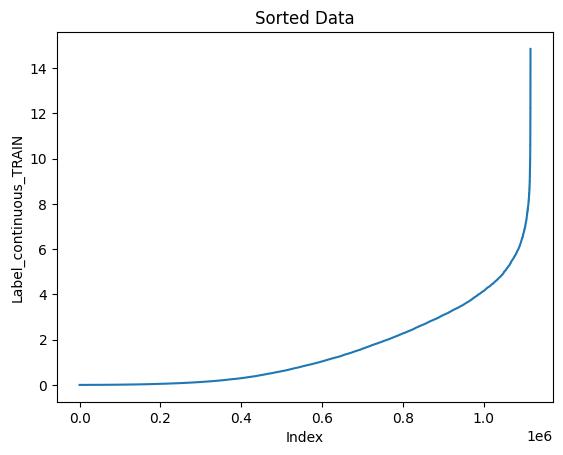

Percentile -  0.6  :  1.41  ----   446444  Samples out of  1115686 ( 40.02 %)
Percentile -  0.7  :  2.13  ----   335292  Samples out of  1115686 ( 30.05 %)
Percentile -  0.75  :  2.56  ----   278842  Samples out of  1115686 ( 24.99 %)
Percentile -  0.8  :  3.02  ----   223242  Samples out of  1115686 ( 20.01 %)
Percentile -  0.85  :  3.53  ----   167248  Samples out of  1115686 ( 14.99 %)
Percentile -  0.9  :  4.22  ----   111590  Samples out of  1115686 ( 10.0 %)
Percentile -  0.95  :  5.21  ----   55924  Samples out of  1115686 ( 5.01 %)
Percentile -  0.99  :  7.2  ----   11210  Samples out of  1115686 ( 1.0 %)


In [194]:
Thresh_DF = pd.DataFrame({"Label_continuous_TRAIN":Label_continuous_TRAIN,"Label_Binary_TRAIN":list(Raw_Train_Data['Label'])})
sorted_df = Thresh_DF.sort_values('Label_continuous_TRAIN')
sorted_df.reset_index(drop=True, inplace=True)
sorted_df['Index'] = list(sorted_df.index)
# Plot the sorted data
plt.plot(sorted_df['Index'], sorted_df['Label_continuous_TRAIN'])
plt.xlabel('Index')
plt.ylabel('Label_continuous_TRAIN')
plt.title('Sorted Data')
plt.show()


for p in [0.60,0.70,0.75,0.80,0.85,0.90,0.95,0.99]:
    tmp = round(sorted_df['Label_continuous_TRAIN'].quantile(p),2)
    print("Percentile - ",str(p)," : ",tmp," ----  ",len(sorted_df[sorted_df['Label_continuous_TRAIN'] >tmp])," Samples out of ", len(sorted_df),'(',round(100*(len(sorted_df[sorted_df['Label_continuous_TRAIN'] >tmp])/len(sorted_df)),2),"%)")


# **Load or Process Test Data -------------------------**

# **Load or Process Train Data - Main Loop**

In [195]:
Num_Features = Raw_Train_Data.shape[1] -1



if OP["Model_type"] == "Rank_map":
      Prameters = {
          'objective': 'rank:map',
          'tree_method': 'hist',
          'lambdarank_num_pair_per_sample': 8,
          'lambdarank_pair_method': 'topk'
      }

elif OP["Model_type"] == "Rank_ndcg":
      Prameters = {
          'objective': 'rank:ndcg',
          'tree_method': 'hist',
          'lambdarank_num_pair_per_sample': 8,
          'lambdarank_pair_method': 'topk'
      }
else:
      Prameters = {
          'objective': 'rank:ndcg',
          'tree_method': 'hist',
          'lambdarank_num_pair_per_sample': 8,
          'lambdarank_pair_method': 'topk'
      }






if OP["Model_type"] == "CNN":
    ML_Model = CNN_Model(Num_Features)
elif OP["Model_type"] == "Rank_map":
   ML_Model = xgb.XGBRanker(**Prameters)
elif OP["Model_type"] == "Rank_ndcg":
    ML_Model = xgb.XGBRanker(**Prameters)





All_Performnace_Matrix_List = []
if OP["Model_type"] in ["Rank_map","Rank_ndcg"]:
                  # Training the Models
                  ML_Model = Train_Func(  Raw_Train_Data.drop(['Label','Qid','Gene_name','Label_GE'], axis=1),
                                          Raw_Train_Data.loc[:,'Label'].values,
                                          ML_Model,
                                          OP["Model_type"],
                                          Raw_Train_Data.loc[:,'Qid'].values)


                  predictions_dict = Test_Eval_Func(Raw_Test_Data,
                                                    ML_Model,
                                                    OP["Model_type"],
                                                    Naive_cols)

                  #All_Performnace_Matrix_List.append([Metric_accuracy,Metric_ndcg,Metric_spearmanr,Metric_kendalltau])
                  #All_Performnace_Matrix_DF = pd.DataFrame(All_Performnace_Matrix_List,columns=["Metric_accuracy","Metric_ndcg","Metric_spearmanr","Metric_kendalltau"])
                  Model_B_name = OP["Save_Folder_Name"]+"/Model_"+OP["Model_type"]+"Ranking_Models"+"_"+OP["Name_Save_load_Data"]+".pkl"
                  joblib.dump({ML_Model}, OP["Drive_Dir"]+Model_B_name)
                  with open(OP["Main_Dir"]+'All_Performance_DF'+'.pkl', 'wb') as file1:
                      pickle.dump(predictions_dict, file1)
                  del file1,Model_B_name


else:

        for i_part,part_indices in enumerate(index_parts):
                  eroooooor




######## Qid 6 - sample: HP28203Me3R1_Healthy  - Results:

OOO Ranking model =====>      NDCG = 0.888   ||   NDCG@10 = 0.642   ||   NDCG@25 = 0.672   ||   NDCG@50 = 0.552   ||   NDCG@100 = 0.527   ||   AH@10 = 7   ||   AH@25 = 14   ||   AH@50 = 16   ||   Spearman = 0.314   ||   Spearman@25 = 0.782   ||   Spearman@100 = 0.583   ||   KendallTau = 0.213   ||   KendallTau@25 = 0.6   ||   KendallTau@100 = 0.418 

OOO Naive model =====>      NDCG = 0.889   ||   NDCG@10 = 0.286   ||   NDCG@25 = 0.307   ||   NDCG@50 = 0.348   ||   NDCG@100 = 0.36   ||   AH@10 = 0   ||   AH@25 = 1   ||   AH@50 = 1   ||   Spearman = 0.534   ||   Spearman@25 = -0.049   ||   Spearman@100 = -0.112   ||   KendallTau = 0.37   ||   KendallTau@25 = -0.04   ||   KendallTau@100 = -0.081 


######## Qid 8 - sample: HP024788_Healthy  - Results:

OOO Ranking model =====>      NDCG = 0.898   ||   NDCG@10 = 0.648   ||   NDCG@25 = 0.654   ||   NDCG@50 = 0.629   ||   NDCG@100 = 0.58   ||   AH@10 = 7   ||   AH@25 = 12   ||   AH

### **TESTING**

### **All List**

In [196]:

result_dic = {"Perf_Ranking":{},"Perf_Naive":{}}
Qid_To_Test = [i for i in list(predictions_dict.keys()) if i not in ['Perf_Rankning_scores', 'Perf_Naive_scores']]
for k in Qid_To_Test:
      DF_k = predictions_dict[k]
      print(f'\n######## Qid {k}  - sample: {QID_Dic[k]}  - Specific Genes Results:\n')
      Perf_Ranking = Ranking_Evaluation(DF_k['GT'], DF_k['My_Pred'],DF_k['GT_Rank'], DF_k['My_Pred_Rank'])
      print('OOO Ranking model =====>      ' +"   ||   ".join([x+" = "+str(round(Perf_Ranking[x],3)) for x in Perf_Ranking])+   ' \n')

      Perf_Naive = Ranking_Evaluation(DF_k['GT'], DF_k['Naive_Pred'],DF_k['GT_Rank'], DF_k['Naive_Rank'])
      print('OOO Naive model =====>      ' +"   ||   ".join([x+" = "+str(round(Perf_Naive[x],3)) for x in Perf_Naive])+   ' \n')

      for key in Perf_Ranking:
        if key in result_dic["Perf_Ranking"]:
            result_dic["Perf_Ranking"][key] += (Perf_Ranking[key]) * (1/len(Qid_To_Test))
            result_dic["Perf_Naive"][key] += (Perf_Naive[key]) * (1/len(Qid_To_Test))
        else:
            result_dic["Perf_Ranking"][key] = Perf_Ranking[key] * (1/len(Qid_To_Test))
            result_dic["Perf_Naive"][key] = Perf_Naive[key] * (1/len(Qid_To_Test))
pd.DataFrame(result_dic)


######## Qid 6  - sample: HP28203Me3R1_Healthy  - Specific Genes Results:

OOO Ranking model =====>      NDCG = 0.888   ||   NDCG@10 = 0.642   ||   NDCG@25 = 0.672   ||   NDCG@50 = 0.552   ||   NDCG@100 = 0.527   ||   AH@10 = 7   ||   AH@25 = 14   ||   AH@50 = 16   ||   Spearman = 0.314   ||   Spearman@25 = 0.782   ||   Spearman@100 = 0.583   ||   KendallTau = 0.213   ||   KendallTau@25 = 0.6   ||   KendallTau@100 = 0.418 

OOO Naive model =====>      NDCG = 0.889   ||   NDCG@10 = 0.286   ||   NDCG@25 = 0.307   ||   NDCG@50 = 0.348   ||   NDCG@100 = 0.36   ||   AH@10 = 0   ||   AH@25 = 1   ||   AH@50 = 1   ||   Spearman = 0.534   ||   Spearman@25 = -0.049   ||   Spearman@100 = -0.112   ||   KendallTau = 0.37   ||   KendallTau@25 = -0.04   ||   KendallTau@100 = -0.081 


######## Qid 8  - sample: HP024788_Healthy  - Specific Genes Results:

OOO Ranking model =====>      NDCG = 0.898   ||   NDCG@10 = 0.648   ||   NDCG@25 = 0.654   ||   NDCG@50 = 0.629   ||   NDCG@100 = 0.58   ||   AH@10

,Perf_Ranking,Perf_Naive
NDCG,0.902834,0.893185
NDCG@10,0.764606,0.226860
NDCG@25,0.749917,0.267426
NDCG@50,0.667806,0.298863
NDCG@100,0.605486,0.333706
AH@10,6.400000,0.000000
AH@25,13.800000,0.200000
AH@50,18.800000,0.400000
Spearman,0.334283,0.518745
Spearman@25,0.722615,-0.106769


## **Specific Genes**

In [197]:
# "ERBB2" instead of  "HER2",
Important_Cancer_Genes = {"Breast":["BRCA1", "BRCA2", "ERBB2", "TP53", "EGFR", "PTEN", "ERBB2","PALB2", "ATM", "CHEK2", "RAD51", "PIK3CA", "AKT1", "CDH1", "BRIP1", "STK11", "NF1", "MUTYH", "NBN","RAD51C"],
                          "Prostate":["FOLH1","BRCA1","BRCA2","PTEN", "TP53","NKX3-1", "TMPRSS2", "GSTP1","AR", "MYC", "KLK3", "FOXA1", "HOXB13", "CDKN1B", "CDKN1A", "NKX3-1", "ATM", "CHEK2", "MSH2","MSH6", "MLH1", "MSH3", "TGFBR2", "ELAC2", "HSD17B2", "HOXB13", "NKX3-1", "DIRC3"],
                          "Colorectal":[ "APC","KRAS", "TP53", "SMAD4", "BRAF", "PIK3CA", "MSH2", "MLH1", "MSH6", "PMS2", "SMAD2","SMAD3", "CTNNB1", "NRAS", "FBXW7", "PTEN", "ATM", "CHK2", "STK11", "TP53BP1"],
                          "NSCLC":["EGFR","KRAS","ALK","ROS1","BRAF","HER2","MET","RET","TP53","STK11","NRAS", "PIK3CA","DDR2","NTRK1", "FGFR1", "MAP2K1", "PTEN", "BRAF", "ERBB2", "MEK1"],
                          "High_SD":["KLK3", "KLK2", "ACPP", "SFTPB", "LGALS4", "KLK4", "CEACAM5", "NPY", "NKX3-1", "PRAC1", "SFTPA1", "DES", "SFTPA2", "CDH17", "GPX2", "SLC45A3", "MUC13", "KRT20", "CDX1", "PHGR1", "CEACAM6", "OR51E2", "HOXB13", "TSPAN8", "FABP1", "PLA2G2A", "RPS4Y1", "GPA33", "OLFM4", "NAPSA"]}

all_genes = [gene for gene_list in Important_Cancer_Genes.values() for gene in gene_list]
Important_Cancer_Genes["All"] = list(set(all_genes))


gene_set_type = Fig_cancerType

result_dic = {"Perf_Ranking":{},"Perf_Naive":{}}
Qid_To_Test = [i for i in list(predictions_dict.keys()) if i not in ['Perf_Rankning_scores', 'Perf_Naive_scores']]
for k in Qid_To_Test:
      DF_k = predictions_dict[k]
      DF_k = DF_k[DF_k['Gene'].isin(Important_Cancer_Genes[gene_set_type])]
      print(f'\n######## Qid {k}  - sample: {QID_Dic[k]}  - Specific Genes Results:\n')
      Perf_Ranking = Ranking_Evaluation(DF_k['GT'], DF_k['My_Pred'],DF_k['GT_Rank'], DF_k['My_Pred_Rank'])
      print('OOO Ranking model =====>      ' +"   ||   ".join([x+" = "+str(round(Perf_Ranking[x],3)) for x in Perf_Ranking])+   ' \n')

      Perf_Naive = Ranking_Evaluation(DF_k['GT'], DF_k['Naive_Pred'],DF_k['GT_Rank'], DF_k['Naive_Rank'])
      print('OOO Naive model =====>      ' +"   ||   ".join([x+" = "+str(round(Perf_Naive[x],3)) for x in Perf_Naive])+   ' \n')

      for key in Perf_Ranking:
        if key in result_dic["Perf_Ranking"]:
            result_dic["Perf_Ranking"][key] += (Perf_Ranking[key]) * (1/len(Qid_To_Test))
            result_dic["Perf_Naive"][key] += (Perf_Naive[key]) * (1/len(Qid_To_Test))
        else:
            result_dic["Perf_Ranking"][key] = Perf_Ranking[key] * (1/len(Qid_To_Test))
            result_dic["Perf_Naive"][key] = Perf_Naive[key] * (1/len(Qid_To_Test))
display(pd.DataFrame(result_dic))

for k in Qid_To_Test:
      print(f'\n######## Qid {k}   - sample: {QID_Dic[k]}  -  Specific Genes Results:\n')
      DF_k = predictions_dict[k]
      DF_k = DF_k[DF_k['Gene'].isin(Important_Cancer_Genes[gene_set_type])]
      display(DF_k)


######## Qid 6  - sample: HP28203Me3R1_Healthy  - Specific Genes Results:

OOO Ranking model =====>      NDCG = 0.616   ||   NDCG@10 = 0.462   ||   NDCG@25 = 0.616   ||   NDCG@50 = 0.616   ||   NDCG@100 = 0.616   ||   AH@10 = 0   ||   AH@25 = 1   ||   AH@50 = 1   ||   Spearman = 0.154   ||   Spearman@25 = 0.154   ||   Spearman@100 = 0.154   ||   KendallTau = 0.098   ||   KendallTau@25 = 0.098   ||   KendallTau@100 = 0.098 

OOO Naive model =====>      NDCG = 0.847   ||   NDCG@10 = 0.795   ||   NDCG@25 = 0.847   ||   NDCG@50 = 0.847   ||   NDCG@100 = 0.847   ||   AH@10 = 0   ||   AH@25 = 0   ||   AH@50 = 0   ||   Spearman = 0.515   ||   Spearman@25 = 0.515   ||   Spearman@100 = 0.515   ||   KendallTau = 0.333   ||   KendallTau@25 = 0.333   ||   KendallTau@100 = 0.333 


######## Qid 8  - sample: HP024788_Healthy  - Specific Genes Results:

OOO Ranking model =====>      NDCG = 0.542   ||   NDCG@10 = 0.301   ||   NDCG@25 = 0.542   ||   NDCG@50 = 0.542   ||   NDCG@100 = 0.542   ||   AH@10

,Perf_Ranking,Perf_Naive
NDCG,0.794675,0.760293
NDCG@10,0.678704,0.575108
NDCG@25,0.794675,0.760293
NDCG@50,0.794675,0.760293
NDCG@100,0.794675,0.760293
AH@10,0.600000,0.000000
AH@25,1.000000,0.200000
AH@50,1.200000,0.200000
Spearman,0.384520,0.092260
Spearman@25,0.384520,0.092260



######## Qid 6   - sample: HP28203Me3R1_Healthy  -  Specific Genes Results:



,Gene,Gene_Exp_Label,GT,GT_Rank,My_Pred,My_Pred_Rank,Naive_Pred,Naive_Rank
952,GSTP1,6.968225,7.000001e+00,228.0,-6.093883,5797.0,-3.989918,5365.0
7971,PTEN,6.247991,6.000000e+00,398.0,-4.233175,128.0,6.247258,68.0
2282,CDKN1B,4.719378,5.000001e+00,1090.0,-5.953769,4742.0,-3.411239,4522.0
4344,MYC,3.930796,4.000001e+00,1670.0,-6.248395,6950.0,-5.099918,9873.0
6622,TGFBR2,3.332497,3.000001e+00,2122.0,-5.710941,3152.0,0.439525,1171.0
5443,ATM,3.156083,3.000001e+00,2274.0,-6.485021,8730.0,2.172902,541.0
9300,CHEK2,1.929436,2.000001e+00,3560.0,-6.175959,6446.0,-1.750167,2773.0
188,BRCA1,1.755306,2.000001e+00,3789.0,-6.115447,5962.0,1.831090,637.0
4622,BRCA2,1.073834,1.000001e+00,4855.0,-5.858495,4104.0,-1.183961,2292.0
7241,NKX3-1,0.261793,4.900369e-07,7118.0,-5.117334,926.0,-3.147658,4179.0



######## Qid 8   - sample: HP024788_Healthy  -  Specific Genes Results:



,Gene,Gene_Exp_Label,GT,GT_Rank,My_Pred,My_Pred_Rank,Naive_Pred,Naive_Rank
12821,GSTP1,6.968225,7.000001e+00,228.0,-5.794382,4706.0,0.542731,3718.0
19840,PTEN,6.247991,6.000000e+00,398.0,-4.857191,932.0,19.979332,63.0
14151,CDKN1B,4.719378,5.000001e+00,1090.0,-5.803624,4769.0,-1.838762,4930.0
16213,MYC,3.930796,4.000001e+00,1670.0,-4.951760,1139.0,0.097248,3910.0
18491,TGFBR2,3.332497,3.000001e+00,2122.0,-5.183128,1805.0,8.157434,1080.0
17312,ATM,3.156083,3.000001e+00,2274.0,-5.706749,4199.0,10.163636,734.0
21169,CHEK2,1.929436,2.000001e+00,3560.0,-5.462998,2905.0,6.248879,1543.0
12057,BRCA1,1.755306,2.000001e+00,3789.0,-6.144772,7062.0,4.257069,2157.0
16491,BRCA2,1.073834,1.000001e+00,4855.0,-5.434894,2778.0,3.610230,2398.0
19110,NKX3-1,0.261793,4.900369e-07,7118.0,-4.585759,521.0,3.964506,2245.0



######## Qid 52   - sample: K4_TRC25_1_Prostate  -  Specific Genes Results:



,Gene,Gene_Exp_Label,GT,GT_Rank,My_Pred,My_Pred_Rank,Naive_Pred,Naive_Rank
28596,KLK3,11.670871,1.200000e+01,1.0,5.055875,1.0,-4.727535,10596.0
30979,NKX3-1,8.394872,8.000000e+00,15.0,-4.883550,1050.0,1.661546,2275.0
33078,TMPRSS2,7.631895,8.000000e+00,47.0,-4.268681,287.0,-4.159843,8789.0
29889,HOXB13,7.339053,7.000000e+00,60.0,-5.597215,3805.0,-4.114885,8589.0
27344,FOXA1,6.769160,7.000000e+00,117.0,-7.410076,11765.0,-3.517148,6770.0
24718,FOLH1,6.376048,6.000000e+00,167.0,-5.975766,6232.0,-4.284102,9201.0
24690,GSTP1,5.357867,5.000001e+00,403.0,-5.649865,4107.0,-1.877369,4401.0
28082,MYC,5.009806,5.000001e+00,536.0,-5.744075,4691.0,-0.888807,3671.0
26020,CDKN1B,4.580846,5.000001e+00,766.0,-5.466993,3131.0,-2.923882,5569.0
31294,AR,4.032495,4.000001e+00,1170.0,-5.472428,3156.0,-2.845987,5474.0



######## Qid 61   - sample: K4_HPC81_1_Prostate  -  Specific Genes Results:



,Gene,Gene_Exp_Label,GT,GT_Rank,My_Pred,My_Pred_Rank,Naive_Pred,Naive_Rank
40465,KLK3,11.670871,1.200000e+01,1.0,1.128612,6.0,-4.058858,7865.0
42848,NKX3-1,8.394872,8.000000e+00,15.0,-4.746675,928.0,2.165597,4234.0
44947,TMPRSS2,7.631895,8.000000e+00,47.0,-4.645865,729.0,-4.835359,10164.0
41758,HOXB13,7.339053,7.000000e+00,60.0,-4.533272,560.0,-2.135969,6271.0
39213,FOXA1,6.769160,7.000000e+00,117.0,-6.957374,11273.0,-4.200323,8154.0
36587,FOLH1,6.376048,6.000000e+00,167.0,-5.440036,3538.0,-1.901705,6137.0
36559,GSTP1,5.357867,5.000001e+00,403.0,-5.671324,4843.0,-0.204815,5287.0
39951,MYC,5.009806,5.000001e+00,536.0,-3.775294,110.0,6.048419,2656.0
37889,CDKN1B,4.580846,5.000001e+00,766.0,-5.436638,3522.0,-2.878502,6708.0
43163,AR,4.032495,4.000001e+00,1170.0,-4.512893,538.0,8.190585,1958.0



######## Qid 97   - sample: K4_NEPC16_Prostate  -  Specific Genes Results:



,Gene,Gene_Exp_Label,GT,GT_Rank,My_Pred,My_Pred_Rank,Naive_Pred,Naive_Rank
52334,KLK3,11.670871,1.200000e+01,1.0,3.935125,1.0,-4.315063,9882.0
54717,NKX3-1,8.394872,8.000000e+00,15.0,-4.038725,292.0,10.578818,2687.0
56816,TMPRSS2,7.631895,8.000000e+00,47.0,-3.753153,146.0,-4.519038,10372.0
53627,HOXB13,7.339053,7.000000e+00,60.0,-3.778403,159.0,5.653387,4108.0
51082,FOXA1,6.769160,7.000000e+00,117.0,-5.125516,2577.0,-0.196086,6132.0
48456,FOLH1,6.376048,6.000000e+00,167.0,-5.875197,6845.0,-0.287443,6175.0
48428,GSTP1,5.357867,5.000001e+00,403.0,-4.981611,2006.0,4.361186,4502.0
51820,MYC,5.009806,5.000001e+00,536.0,-3.923477,214.0,7.778067,3400.0
49758,CDKN1B,4.580846,5.000001e+00,766.0,-5.979515,7496.0,-0.513087,6273.0
55032,AR,4.032495,4.000001e+00,1170.0,-4.350153,561.0,48.533134,12.0


### **Display Ranking Lists*

In [198]:
for k in Qid_To_Test:
      print(f'\n######## Qid {k}   - sample: {QID_Dic[k]}  -  Specific Genes Results:\n')
      DF_k = predictions_dict[k]
      display(DF_k.head(10))


######## Qid 6   - sample: HP28203Me3R1_Healthy  -  Specific Genes Results:



,Gene,Gene_Exp_Label,GT,GT_Rank,My_Pred,My_Pred_Rank,Naive_Pred,Naive_Rank
11563,HBB,14.850700,15.000000,1.0,2.116069,3.0,-5.099918,10503.0
9955,HBA2,14.785039,15.000001,2.0,1.006615,8.0,-5.099917,9397.0
10961,HBA1,14.018334,14.000000,3.0,0.892374,9.0,-5.099918,11265.0
7185,B2M,12.671261,13.000001,4.0,1.851207,5.0,2.731444,401.0
10906,TMSB4X,12.419213,12.000000,5.0,0.467804,10.0,-1.509308,2552.0
7400,FTH1,12.305374,12.000000,6.0,-0.284304,11.0,3.159221,320.0
999,FTL,12.223936,12.000001,7.0,2.125901,2.0,2.204355,535.0
773,ACTB,11.678472,12.000001,8.0,2.061262,4.0,-3.366458,4465.0
11364,HLA-B,11.406468,11.000000,9.0,-2.723695,14.0,7.717219,22.0
9506,IFITM2,11.364891,11.000001,10.0,-4.629157,286.0,-1.396425,2461.0



######## Qid 8   - sample: HP024788_Healthy  -  Specific Genes Results:



,Gene,Gene_Exp_Label,GT,GT_Rank,My_Pred,My_Pred_Rank,Naive_Pred,Naive_Rank
23432,HBB,14.850700,15.000000,1.0,0.890130,10.0,-4.370915,8098.0
21824,HBA2,14.785039,15.000001,2.0,1.167267,7.0,-4.835358,9971.0
22830,HBA1,14.018334,14.000000,3.0,2.878570,2.0,-4.729231,9444.0
19054,B2M,12.671261,13.000001,4.0,2.074958,4.0,12.681731,402.0
22775,TMSB4X,12.419213,12.000000,5.0,0.996884,9.0,8.767461,976.0
19269,FTH1,12.305374,12.000000,6.0,0.084400,11.0,23.157174,30.0
12868,FTL,12.223936,12.000001,7.0,1.795634,5.0,9.705878,806.0
12642,ACTB,11.678472,12.000001,8.0,2.123201,3.0,-1.471212,4703.0
23233,HLA-B,11.406468,11.000000,9.0,-2.326002,15.0,14.623581,261.0
21375,IFITM2,11.364891,11.000001,10.0,-4.161879,209.0,3.350621,2508.0



######## Qid 52   - sample: K4_TRC25_1_Prostate  -  Specific Genes Results:



,Gene,Gene_Exp_Label,GT,GT_Rank,My_Pred,My_Pred_Rank,Naive_Pred,Naive_Rank
28596,KLK3,11.670871,12.000001,1.0,5.055875,1.0,-4.727535,10596.0
24737,FTL,10.580967,11.000001,2.0,1.236332,8.0,6.129789,819.0
24511,ACTB,9.908877,10.000001,3.0,1.989636,3.0,-4.100818,8524.0
31100,KLK2,9.620776,10.000001,4.0,2.204837,2.0,-4.428243,9794.0
23951,ACPP,9.618431,10.000001,5.0,1.495595,7.0,-2.618989,5183.0
30923,B2M,8.833561,9.000001,6.0,1.720000,5.0,12.452905,174.0
34112,PSAP,8.821795,9.000001,7.0,-1.907010,13.0,3.171134,1624.0
26040,GAPDH,8.737622,9.000000,8.0,-1.452763,12.0,6.335782,785.0
29850,SLC45A3,8.684719,9.000001,9.0,-2.498612,20.0,3.521703,1495.0
31707,RPS21,8.605551,9.000000,10.0,-2.508720,21.0,9.962670,333.0



######## Qid 61   - sample: K4_HPC81_1_Prostate  -  Specific Genes Results:



,Gene,Gene_Exp_Label,GT,GT_Rank,My_Pred,My_Pred_Rank,Naive_Pred,Naive_Rank
40465,KLK3,11.670871,12.000001,1.0,1.128612,6.0,-4.058858,7865.0
36606,FTL,10.580967,11.000001,2.0,1.915936,3.0,9.541005,1591.0
36380,ACTB,9.908877,10.000001,3.0,1.788325,4.0,0.214326,5118.0
42969,KLK2,9.620776,10.000001,4.0,2.131117,2.0,-5.099917,10468.0
35820,ACPP,9.618431,10.000001,5.0,1.606143,5.0,-2.972612,6777.0
42792,B2M,8.833561,9.000001,6.0,2.396143,1.0,16.961001,370.0
45981,PSAP,8.821795,9.000001,7.0,-1.674676,12.0,12.961434,862.0
37909,GAPDH,8.737622,9.000000,8.0,-2.221963,17.0,9.576841,1585.0
41719,SLC45A3,8.684719,9.000001,9.0,-2.387136,20.0,10.812387,1292.0
43576,RPS21,8.605551,9.000000,10.0,-2.310026,18.0,13.610944,753.0



######## Qid 97   - sample: K4_NEPC16_Prostate  -  Specific Genes Results:



,Gene,Gene_Exp_Label,GT,GT_Rank,My_Pred,My_Pred_Rank,Naive_Pred,Naive_Rank
52334,KLK3,11.670871,12.000001,1.0,3.935125,1.0,-4.315063,9882.0
48475,FTL,10.580967,11.000001,2.0,1.868038,5.0,20.093340,891.0
48249,ACTB,9.908877,10.000001,3.0,2.438560,2.0,-1.752785,6854.0
54838,KLK2,9.620776,10.000001,4.0,2.120097,4.0,-2.531420,7334.0
47689,ACPP,9.618431,10.000001,5.0,1.802029,6.0,-3.259760,8064.0
54661,B2M,8.833561,9.000001,6.0,2.166016,3.0,16.555624,1397.0
57850,PSAP,8.821795,9.000001,7.0,-2.043069,13.0,7.419072,3520.0
49778,GAPDH,8.737622,9.000000,8.0,-2.046322,14.0,19.816111,920.0
53588,SLC45A3,8.684719,9.000001,9.0,-2.491538,20.0,19.662880,944.0
55445,RPS21,8.605551,9.000000,10.0,-2.111372,16.0,37.806849,51.0


### **Feature Importance**

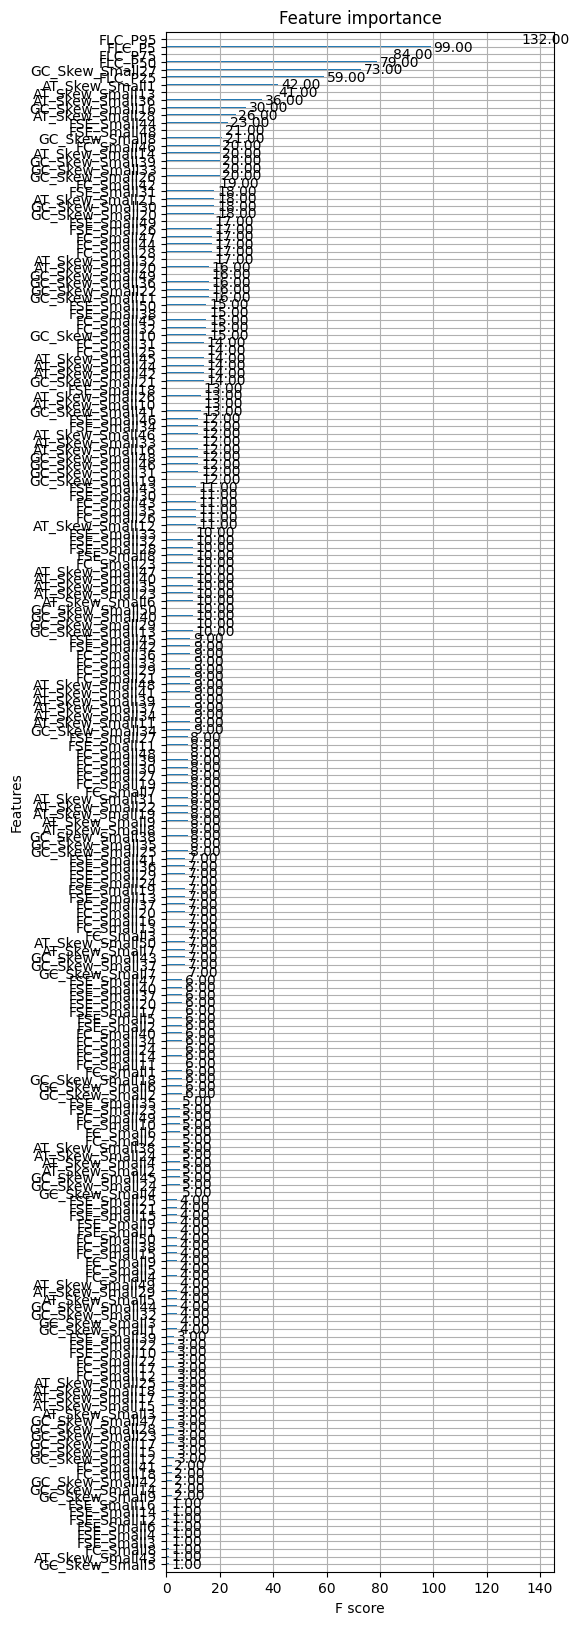

In [199]:
plt.figure(figsize=(5, 20))  # Set the figure size (width, height) as desired
xgb.plot_importance(ML_Model, importance_type='weight', ax=plt.gca(),values_format= "{v:.2f}")  # Use ax=plt.gca() to specify the current axes
plt.show()



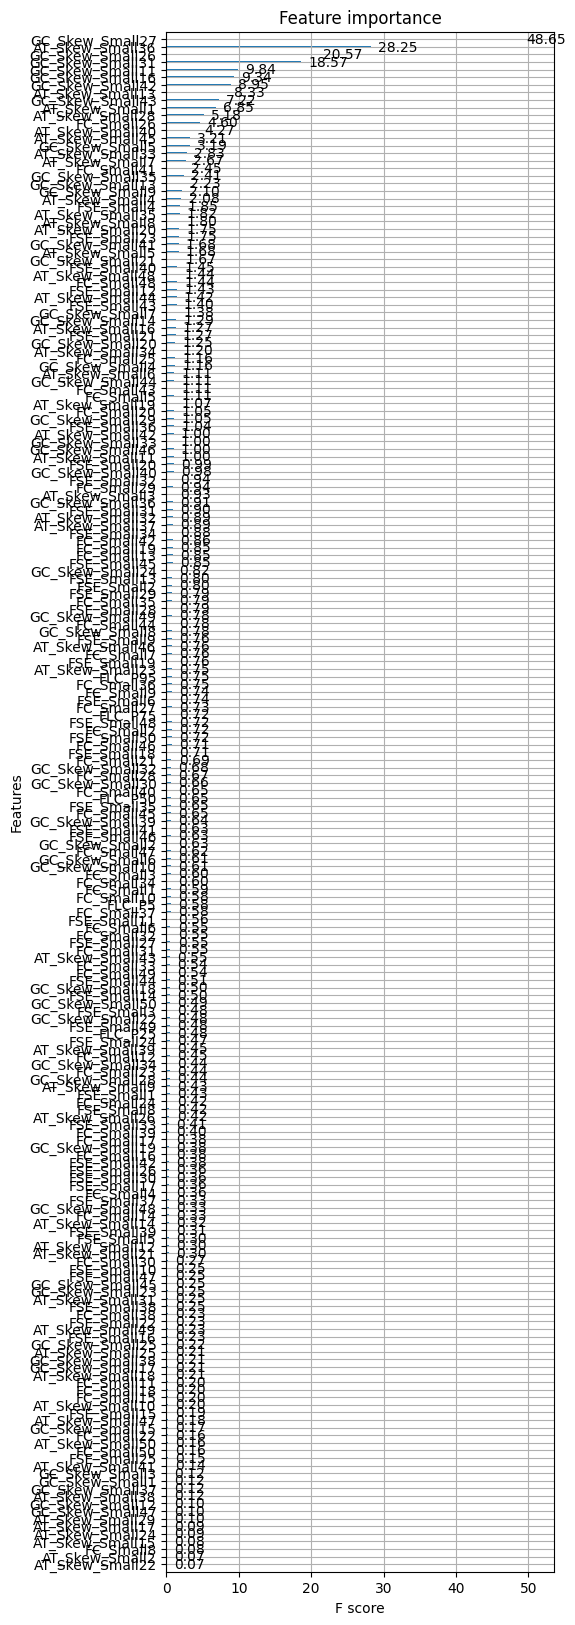

In [200]:
plt.figure(figsize=(5, 20))  # Set the figure size (width, height) as desired
xgb.plot_importance(ML_Model, importance_type='gain', ax=plt.gca(),values_format= "{v:.2f}")  # Use ax=plt.gca() to specify the current axes
plt.show()

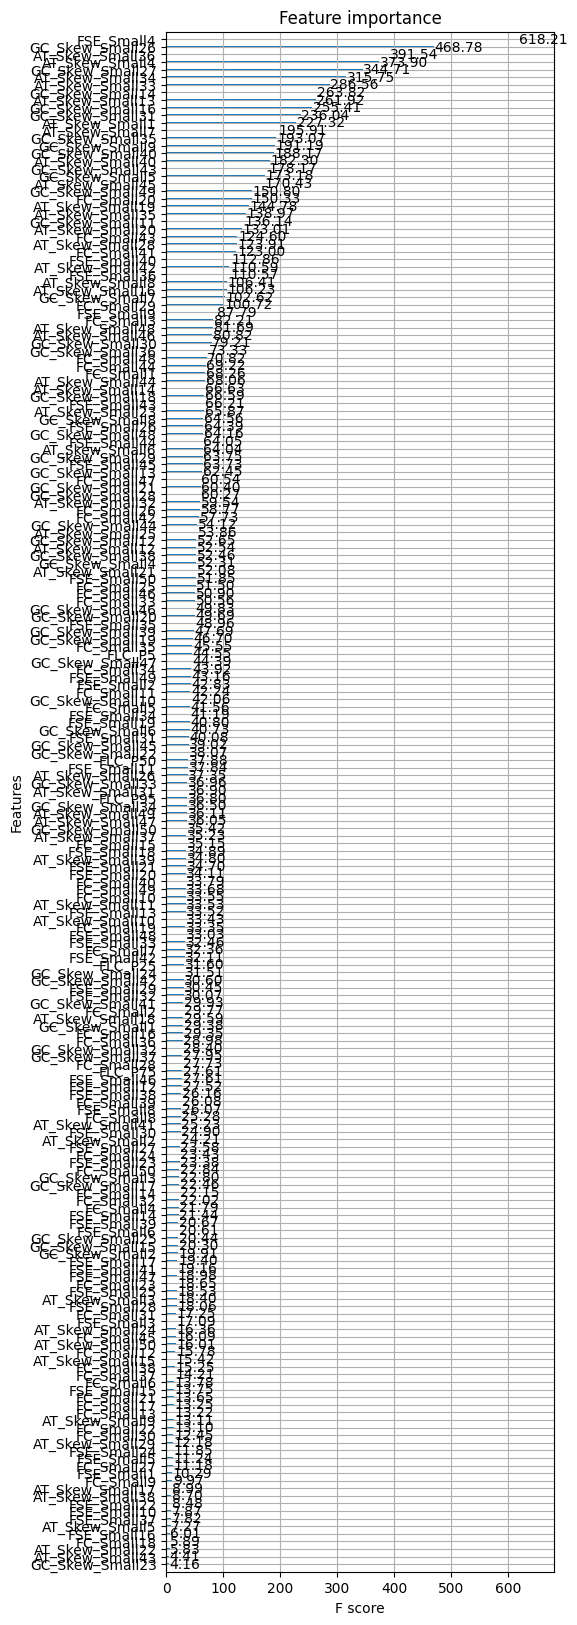

<Figure size 1500x600 with 0 Axes>

In [201]:
plt.figure(figsize=(5, 20))  # Set the figure size (width, height) as desired
xgb.plot_importance(ML_Model, importance_type='cover', ax=plt.gca(),values_format= "{v:.2f}")  # Use ax=plt.gca() to specify the current axes
plt.figure(figsize=(15, 6))
plt.show()



<ipython-input-188-88776d83c184>:214: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(features_to_plot, fontsize=7)  # You can adjust the fontsize as needed


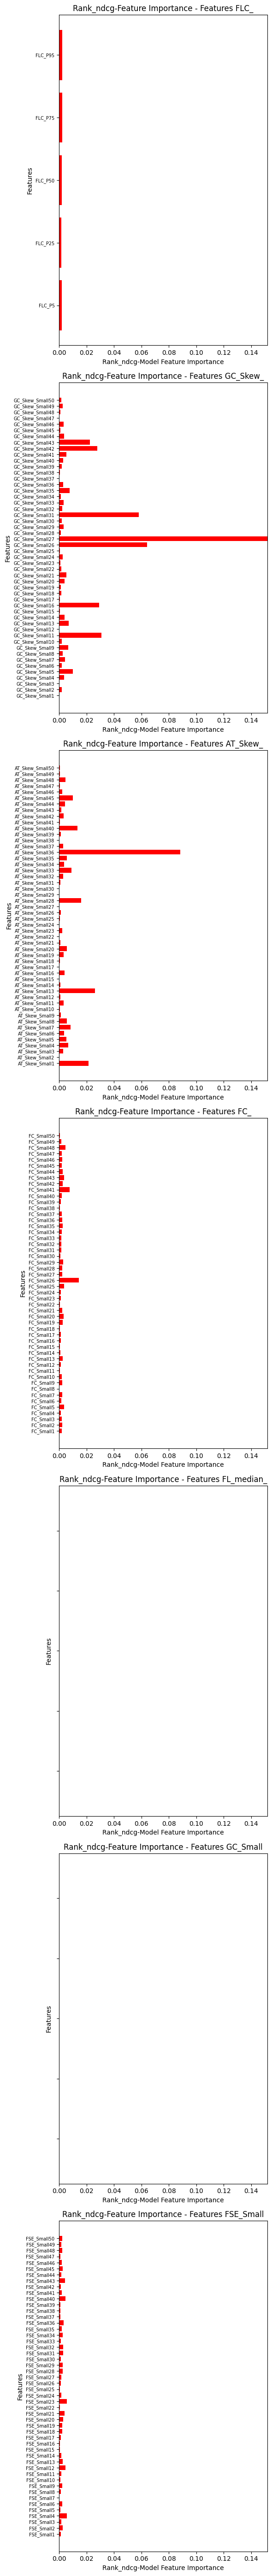

In [202]:
Feature_Types = ["FLC_","GC_Skew_","AT_Skew_","FC_","FL_median_","GC_Small","FSE_Small"]


Feature_Importance_Plots( ML_Model,
                          OP["Model_type"],
                          Feature_Types)



### **GSEA**



In [203]:
import gseapy as gp
from gseapy import enrichment_map
from gseapy import dotplot

In [204]:
gene_sets_type = ['Elsevier_Pathway_Collection'],  #  Elsevier_Pathway_Collection GO_Cellular_Component_2023 GO_Biological_Process_2023  GO_Molecular_Function_2023
all_Gene_sets = gp.get_library_name()
display(HTML(pd.DataFrame(all_Gene_sets).to_html()))

,0
0,ARCHS4_Cell-lines
1,ARCHS4_IDG_Coexp
2,ARCHS4_Kinases_Coexp
3,ARCHS4_TFs_Coexp
4,ARCHS4_Tissues
5,Achilles_fitness_decrease
6,Achilles_fitness_increase
7,Aging_Perturbations_from_GEO_down
8,Aging_Perturbations_from_GEO_up
9,Allen_Brain_Atlas_10x_scRNA_2021


In [205]:
for k in Qid_To_Test:
      print(f'\n######## Qid {k}   - sample: {QID_Dic[k]}  -  Specific Genes Results:\n')


######## Qid 6   - sample: HP28203Me3R1_Healthy  -  Specific Genes Results:


######## Qid 8   - sample: HP024788_Healthy  -  Specific Genes Results:


######## Qid 52   - sample: K4_TRC25_1_Prostate  -  Specific Genes Results:


######## Qid 61   - sample: K4_HPC81_1_Prostate  -  Specific Genes Results:


######## Qid 97   - sample: K4_NEPC16_Prostate  -  Specific Genes Results:



In [206]:
#Predicted_Ranks['Naive_Pred'].value_counts().reset_index().head(20)


In [207]:

Patient_ID = 97

GSEA_Data_Dic = {}
GSEA_Models_Dic = {}
Predicted_Ranks = predictions_dict[Patient_ID]


# Actual values
#GSEA_Data_Dic['Ranking_Pred_Sorted'] = Predicted_Ranks.sort_values(by='My_Pred', ascending=False).loc[:,['Gene','My_Pred']]
#GSEA_Data_Dic['GT_Sorted'] = Predicted_Ranks.sort_values(by='Gene_Exp_Label', ascending=False).loc[:,['Gene','Gene_Exp_Label']]
#GSEA_Data_Dic['Naive_Pred_Sorted'] = Predicted_Ranks.sort_values(by='Naive_Pred', ascending=False).loc[:,['Gene','Naive_Pred']]


# Rank values*10
#Predicted_Ranks['My_Pred_Rank_Minus'] = ((len(Predicted_Ranks)+1) - Predicted_Ranks['My_Pred_Rank'])*10
#Predicted_Ranks['GT_Rank_Minus'] = ((len(Predicted_Ranks)+1) - Predicted_Ranks['GT_Rank'])*10
#Predicted_Ranks['Naive_Rank_Minus'] = ((len(Predicted_Ranks)+1) - Predicted_Ranks['Naive_Rank'])*10
#GSEA_Data_Dic['Ranking_Pred_Sorted'] = Predicted_Ranks.loc[:,['Gene','My_Pred_Rank_Minus']]
#GSEA_Data_Dic['GT_Sorted'] = Predicted_Ranks.loc[:,['Gene','GT_Rank_Minus']]
#GSEA_Data_Dic['Naive_Pred_Sorted'] = Predicted_Ranks.loc[:,['Gene','Naive_Rank_Minus']]

# Normalize 0-10
for COL in ["Naive_Pred","GT","My_Pred","Gene_Exp_Label"]:
    Predicted_Ranks[COL] = ((Predicted_Ranks[COL] - Predicted_Ranks[COL].min()) / (Predicted_Ranks[COL].max() - Predicted_Ranks[COL].min())) * 10
GSEA_Data_Dic['Ranking_Pred_Sorted'] = Predicted_Ranks.sort_values(by='My_Pred', ascending=False).loc[:,['Gene','My_Pred']]
GSEA_Data_Dic['GT_Sorted'] = Predicted_Ranks.sort_values(by='Gene_Exp_Label', ascending=False).loc[:,['Gene','Gene_Exp_Label']]
GSEA_Data_Dic['Naive_Pred_Sorted'] = Predicted_Ranks.sort_values(by='Naive_Pred', ascending=False).loc[:,['Gene','Naive_Pred']]



print('Number of Genes: ',len((Predicted_Ranks)))
for k_model in list(GSEA_Data_Dic.keys()):
      GSEA_Models_Dic[k_model] = gp.prerank(rnk=GSEA_Data_Dic[k_model], #
                                        gene_sets= gene_sets_type[0],
                                        #threads=4,
                                        #min_size=50,
                                        #max_size=1000,
                                        #permutation_num=100, # reduce number to speed up testing
                                        #outdir=None, # don't write to disk
                                        seed=6,
                                        verbose=True, # see what's going on behind the scenes
                                        )



#| {
#|  term: gene set name,
#|  es: enrichment score,
#|  nes: normalized enrichment score,
#|  pval:  Nominal p-value (from the null distribution of the gene set,
#|  fdr: FDR qvalue (adjusted False Discory Rate),
#|  fwerp: Family wise error rate p-values,
#|  tag %: Percent of gene set before running enrichment peak (ES),
#|  gene %: Percent of gene list before running enrichment peak (ES),
#|  lead_genes: leading edge genes (gene hits before running enrichment peak),
#|  matched genes: genes matched to the data,
#| }


2023-11-28 23:20:23,435 [INFO] Input gene rankings contains duplicated IDs
2023-11-28 23:20:23,459 [INFO] Parsing data files for GSEA.............................
2023-11-28 23:20:23,460 [INFO] Enrichr library gene sets already downloaded in: /root/.cache/gseapy, use local file
2023-11-28 23:20:23,497 [INFO] 0862 gene_sets have been filtered out when max_size=500 and min_size=15
2023-11-28 23:20:23,500 [INFO] 0859 gene_sets used for further statistical testing.....
2023-11-28 23:20:23,501 [INFO] Start to run GSEA...Might take a while..................


Number of Genes:  11869


2023-11-28 23:20:43,247 [INFO] Input gene rankings contains duplicated IDs
2023-11-28 23:20:43,271 [INFO] Parsing data files for GSEA.............................
2023-11-28 23:20:43,272 [INFO] Enrichr library gene sets already downloaded in: /root/.cache/gseapy, use local file
2023-11-28 23:20:43,310 [INFO] 0862 gene_sets have been filtered out when max_size=500 and min_size=15
2023-11-28 23:20:43,313 [INFO] 0859 gene_sets used for further statistical testing.....
2023-11-28 23:20:43,315 [INFO] Start to run GSEA...Might take a while..................
2023-11-28 23:21:02,862 [INFO] Congratulations. GSEApy runs successfully................

2023-11-28 23:21:02,871 [INFO] Input gene rankings contains duplicated IDs
2023-11-28 23:21:02,895 [INFO] Parsing data files for GSEA.............................
2023-11-28 23:21:02,896 [INFO] Enrichr library gene sets already downloaded in: /root/.cache/gseapy, use local file
2023-11-28 23:21:02,933 [INFO] 0862 gene_sets have been filtered out when

In [208]:
GSEA_Analysis_Dic = {}
for k_model in list(GSEA_Data_Dic.keys()):
    out = []
    for term in list(GSEA_Models_Dic[k_model].results.keys()):
      L = [term]
      for c in ['fdr','pval','es','nes']:
        L.append(GSEA_Models_Dic[k_model].results[term][c])
      out.append(L)
    out_df_Naive = pd.DataFrame(out,columns=['Term','fdr','pval','es','nes']).sort_values('fdr').reset_index(drop=True)
    GSEA_Analysis_Dic[k_model] = out_df_Naive
    del out,term,c,L,out_df_Naive




display(HTML(pd.concat([ GSEA_Analysis_Dic[k_model].rename(columns=lambda x: k_model+'_' + str(x)) for k_model in GSEA_Analysis_Dic],axis=1).head(10).to_html()))

,Ranking_Pred_Sorted_Term,Ranking_Pred_Sorted_fdr,Ranking_Pred_Sorted_pval,Ranking_Pred_Sorted_es,Ranking_Pred_Sorted_nes,GT_Sorted_Term,GT_Sorted_fdr,GT_Sorted_pval,GT_Sorted_es,GT_Sorted_nes,Naive_Pred_Sorted_Term,Naive_Pred_Sorted_fdr,Naive_Pred_Sorted_pval,Naive_Pred_Sorted_es,Naive_Pred_Sorted_nes
0,Elsevier_Pathway_Collection__Synovial Fibroblast Proliferation in Rheumatoid Arthritis,0.0,0.0,0.584487,2.988582,Elsevier_Pathway_Collection__Leptin and CCK8 Activate Nodose Ganglia Neuron,0.015008,0.000000,0.804291,1.583581,Elsevier_Pathway_Collection__SOCS in Negative Feedback Regulation in Myocarditis,0.043984,0.008032,0.734394,1.451498
1,Elsevier_Pathway_Collection__IL6 Expression Targets -> Nociception,0.0,0.0,0.628288,2.642282,Elsevier_Pathway_Collection__Telomer Attrition Triggers Genomic Instability,0.015758,0.000000,0.804648,1.572306,Elsevier_Pathway_Collection__Skeletal Muscle Wasting in Cancer Cachexia,0.045879,0.000000,0.713557,1.451810
2,Elsevier_Pathway_Collection__EGFR Signaling,0.0,0.0,0.588278,2.617174,Elsevier_Pathway_Collection__Age-Related Cataract,0.017509,0.000000,0.826556,1.593026,"Elsevier_Pathway_Collection__Overt Hypothyroidism, Primary",0.046325,0.000000,0.726305,1.459396
3,Elsevier_Pathway_Collection__Acute Myeloid Leukemia,0.0,0.0,0.480911,2.657563,Elsevier_Pathway_Collection__Golgi to Endosome Transport,0.020010,0.000000,0.833990,1.610078,Elsevier_Pathway_Collection__KISS1 Production Impairment in Hypogonadotropic hypogonadism,0.047449,0.002006,0.726237,1.422169
4,Elsevier_Pathway_Collection__Lipoxin A4/FPR2-Related Neutrophil Depression,0.0,0.0,0.611833,2.622557,Elsevier_Pathway_Collection__Proteins with Altered Expression in Prostate Cancer,0.045424,0.000000,0.748140,1.510752,Elsevier_Pathway_Collection__IgE Induces Airway Smooth Muscle Cell Proliferation,0.047902,0.001000,0.686143,1.420608
5,Elsevier_Pathway_Collection__TGFB Signaling activation by Blocking of Tumor Suppressors,0.0,0.0,0.518991,2.656434,Elsevier_Pathway_Collection__Glycolysis,0.059459,0.001006,0.769127,1.479256,Elsevier_Pathway_Collection__HTR5 -> TNF Production,0.048096,0.002008,0.745400,1.452137
6,Elsevier_Pathway_Collection__TGFB Family in Epithelial to Mesenchymal Transition in Cancer,0.0,0.0,0.520760,2.883128,Elsevier_Pathway_Collection__ALK Associated Neuroblastoma,0.063366,0.000000,0.761445,1.483862,Elsevier_Pathway_Collection__CD38/CD3 -> JUN/FOS/NF-kB Signaling in T-cell Proliferation,0.048202,0.001003,0.706656,1.416670
7,Elsevier_Pathway_Collection__Chronic Myeloid Leukemia,0.0,0.0,0.546091,2.740180,Elsevier_Pathway_Collection__TRPM4/6/7/8 Signaling in Arterial Hypertension (Hypothesis),0.098451,0.000000,0.706833,1.440671,Elsevier_Pathway_Collection__TRPM7/8 in Pancreatic Adenocarcinoma,0.048270,0.003003,0.722626,1.412926
8,Elsevier_Pathway_Collection__ERK/MAPK Canonical Signaling,0.0,0.0,0.600170,2.870023,Elsevier_Pathway_Collection__NTSR1 Expression Targets,0.100608,0.005010,0.747371,1.444009,Elsevier_Pathway_Collection__CD38/CD19 -> JUN/FOS/NF-kB Signaling in B-cell Proliferation,0.048537,0.002002,0.706773,1.436211
9,Elsevier_Pathway_Collection__WNT in Epithelial to Mesenchymal Transition in Cancer,0.0,0.0,0.544915,2.621802,Elsevier_Pathway_Collection__Hepatic Stellate Cells in non-Alcoholic Fatty Liver Disease,0.109432,0.000000,0.697687,1.445544,Elsevier_Pathway_Collection__Synovial Fibroblast Activation in Psoriatic Arthritis,0.048786,0.000000,0.687690,1.422240


Model's Name:  Ranking_Pred_Sorted
Model's Name:  GT_Sorted
Model's Name:  Naive_Pred_Sorted
Model's Name:  Ranking_Pred_Sorted
Model's Name:  GT_Sorted
Model's Name:  Naive_Pred_Sorted
Model's Name:  Ranking_Pred_Sorted
Model's Name:  GT_Sorted
Model's Name:  Naive_Pred_Sorted


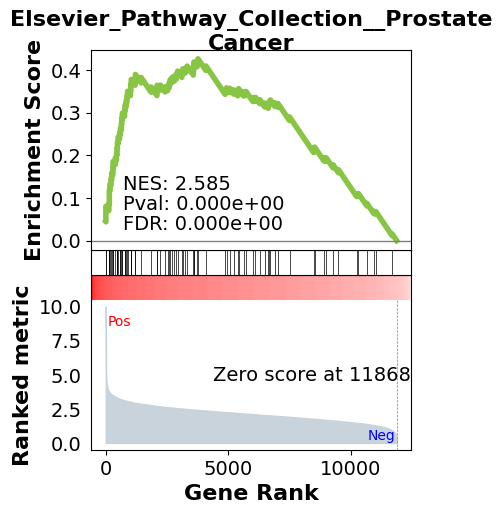

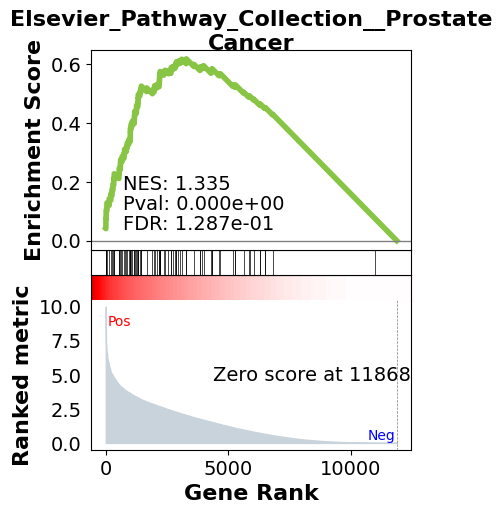

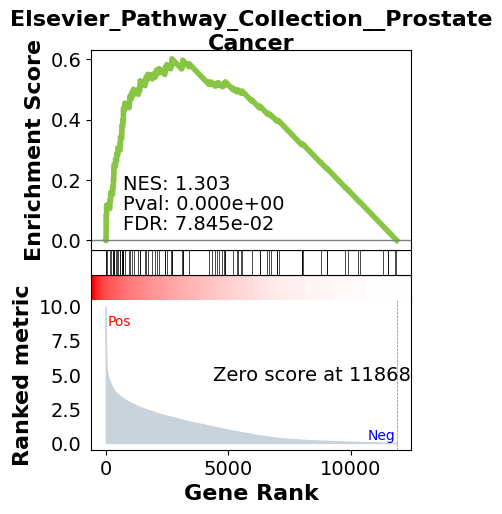

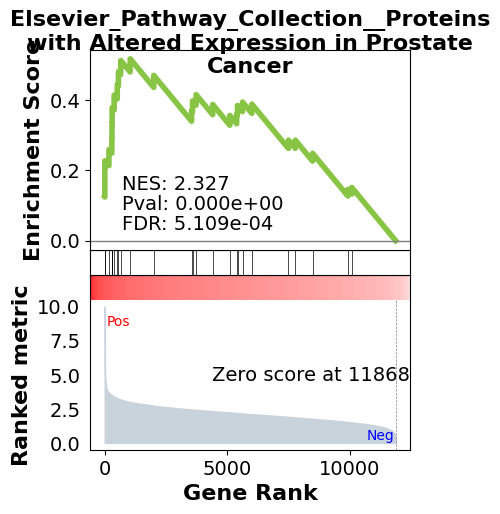

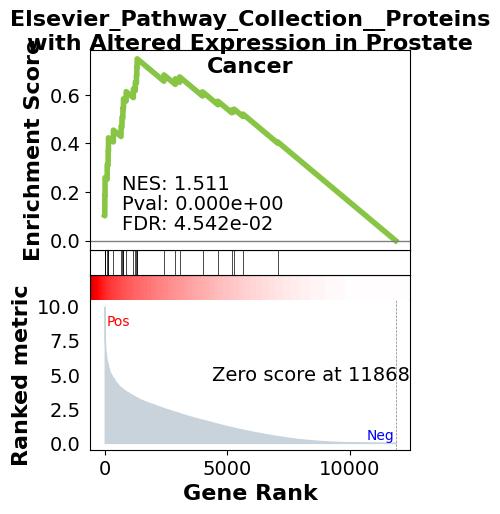

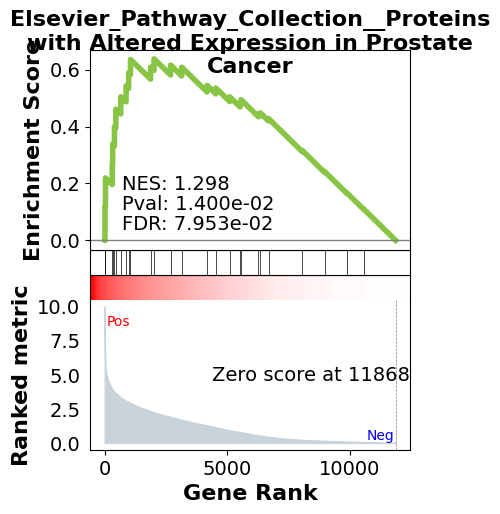

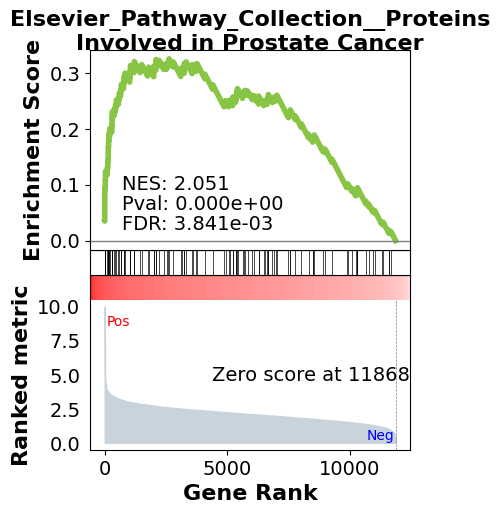

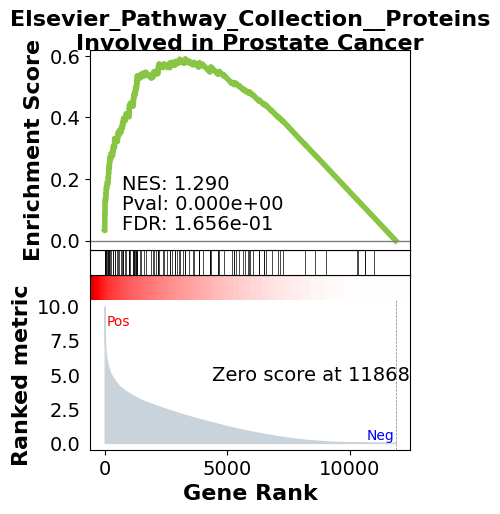

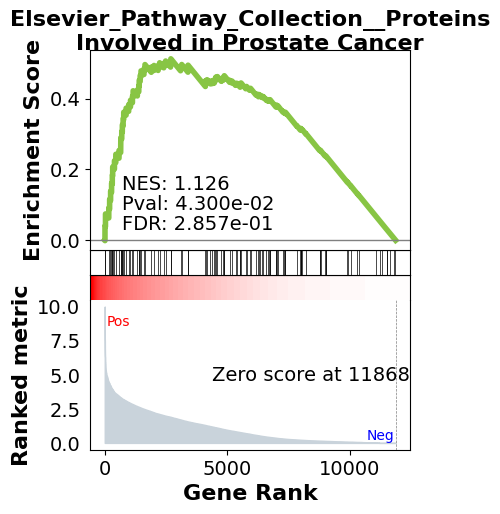

In [209]:
Term_To_Serach = "prostate"
termslist = GSEA_Analysis_Dic[k_model].Term
Cancer_Related_Idx = [i for i,j in enumerate(termslist) if Term_To_Serach in j.lower()]
#Specific_Term = termslist[Cancer_Related_Idx[2]]

for Specific_Term in termslist[Cancer_Related_Idx]:
    # Check thresholds
    Thresh_sig = []
    for k_model in list(GSEA_Data_Dic.keys()):
      DF_SIG = GSEA_Analysis_Dic[k_model][GSEA_Analysis_Dic[k_model]["Term"] == Specific_Term]
      Thresh_sig.append((DF_SIG["fdr"]<0.05).values[0] )
      Thresh_sig.append((DF_SIG["pval"]<0.05).values[0])
    del DF_SIG
    if sum(Thresh_sig) >= 4:
        for k_model in list(GSEA_Data_Dic.keys()):
            print("Model's Name: ",k_model)
            axs = GSEA_Models_Dic[k_model].plot(terms=Specific_Term)

Model's Name:  Ranking_Pred_Sorted
Model's Name:  GT_Sorted
Model's Name:  Naive_Pred_Sorted


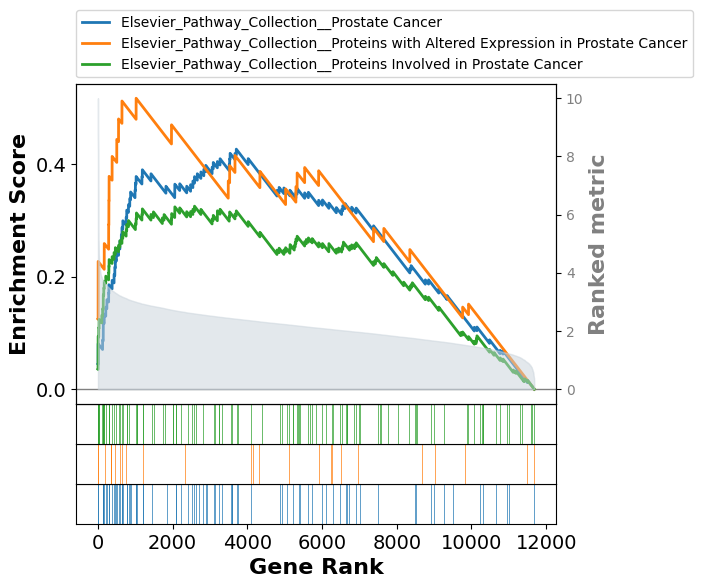

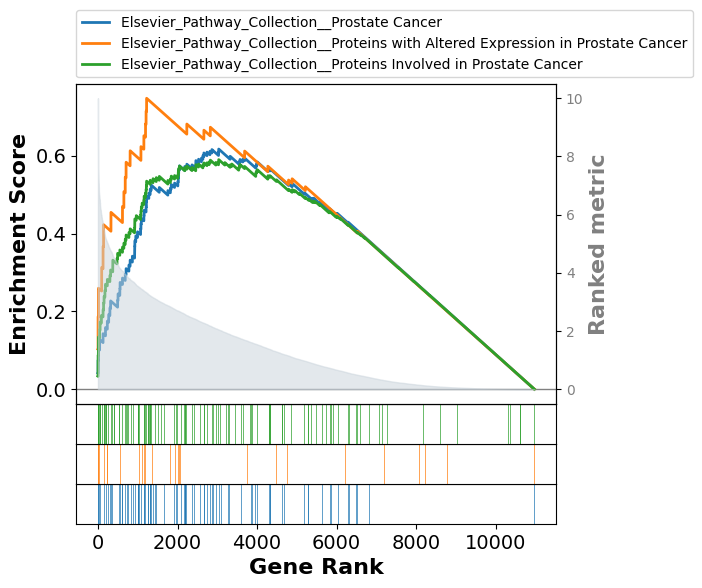

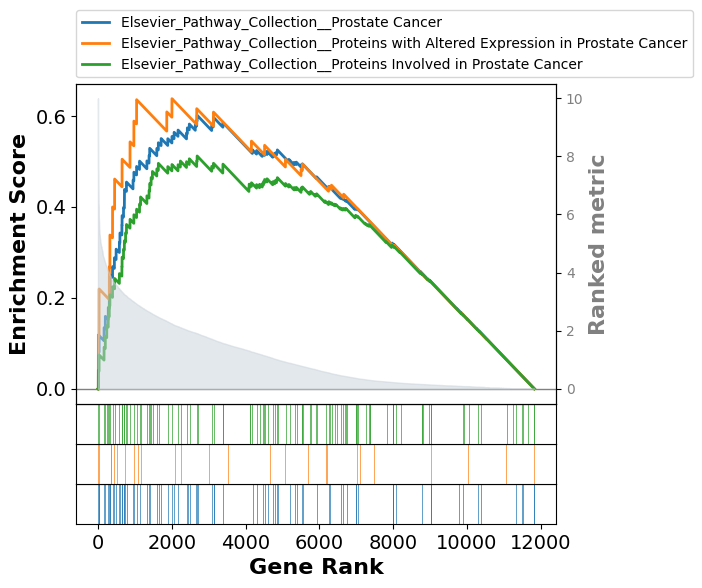

In [210]:

for k_model in list(GSEA_Data_Dic.keys()):
    print("Model's Name: ",k_model)
    axs = GSEA_Models_Dic[k_model].plot(terms=termslist[Cancer_Related_Idx],
                      #legend_kws={'loc': (1.2, 0)}, # set the legend loc
                      show_ranking=True, # whether to show the second yaxis
                      figsize=(3,4)
                      )

Model's Name:  Ranking_Pred_Sorted
Model's Name:  GT_Sorted
Model's Name:  Naive_Pred_Sorted


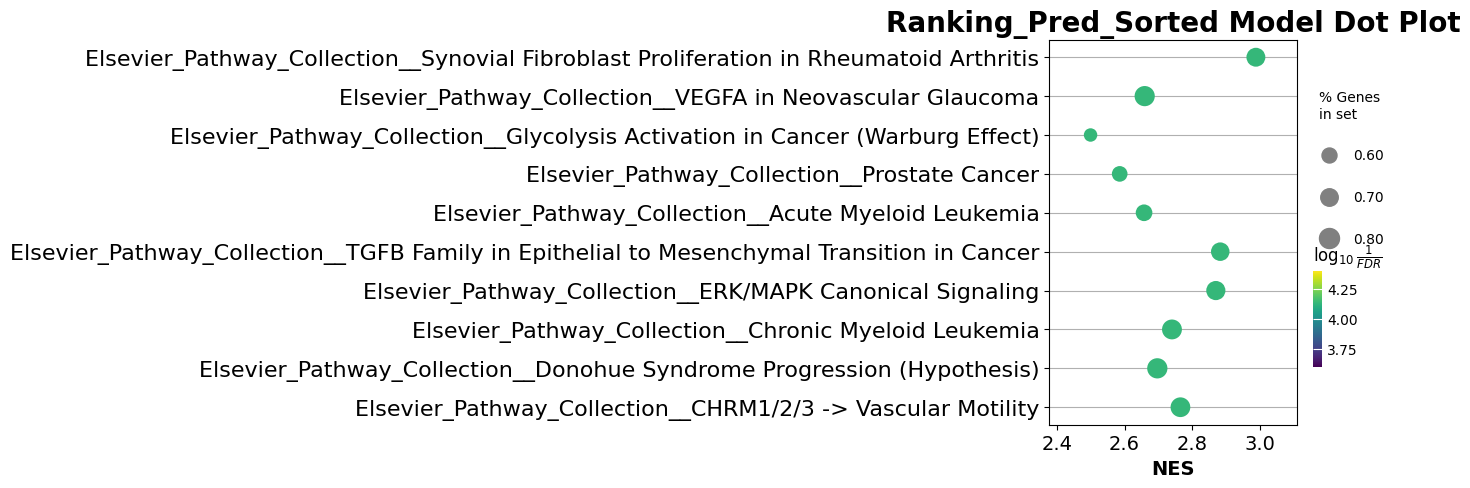

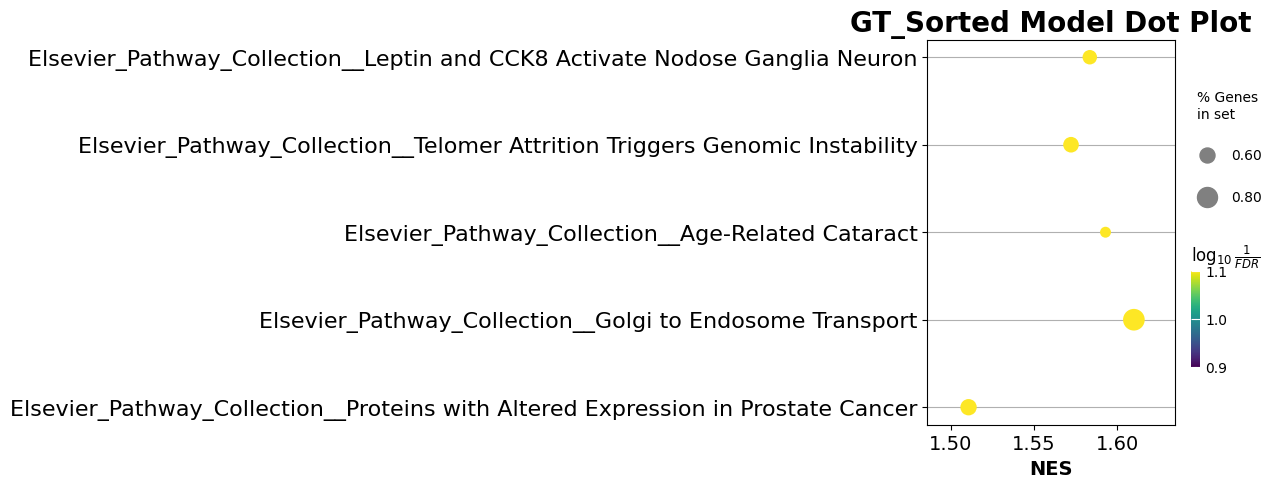

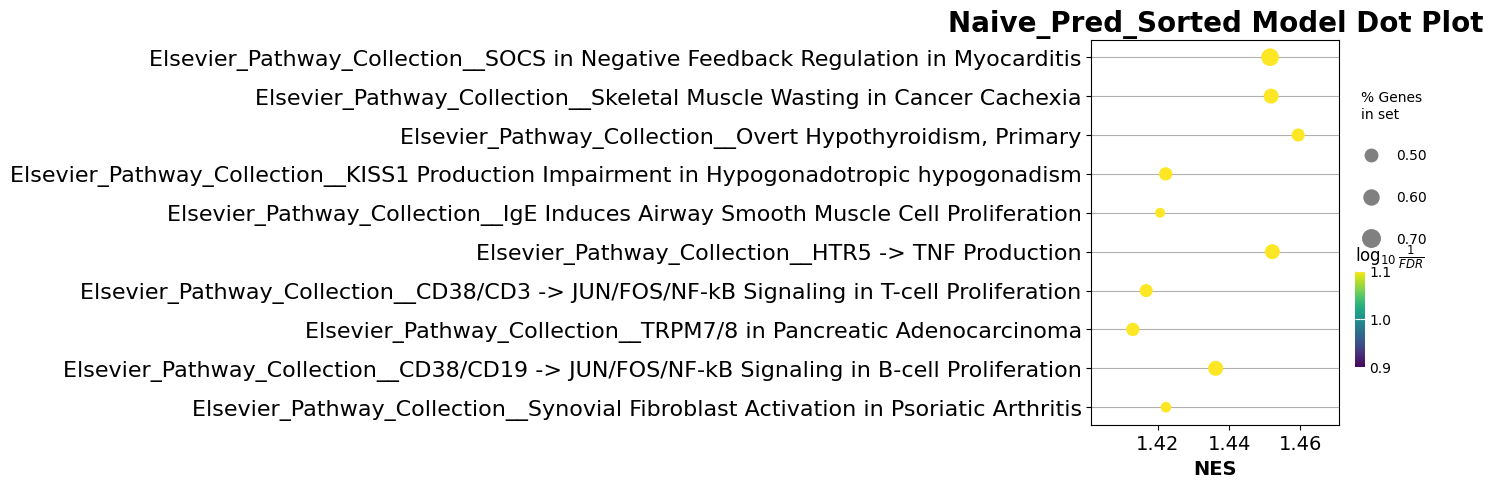

In [211]:
my_cutoff = 0.05
for k_model in list(GSEA_Data_Dic.keys()):
    print("Model's Name: ",k_model)
    ax = dotplot(GSEA_Models_Dic[k_model].res2d,
             column="FDR q-val",
             title= k_model+" Model Dot Plot",
             cmap=plt.cm.viridis,
             size=3, # adjust dot size
             figsize=(4,5),
             cutoff= my_cutoff,
             show_ring=False)





In [212]:
GSEA_Enrichr_Dic = {}
for k_model in list(GSEA_Data_Dic.keys()):
      AAA = GSEA_Data_Dic[k_model].sort_values(by=[list(set(GSEA_Data_Dic[k_model].columns)-set(['Gene']))[0]], ascending=[False]).head(1000)
      My_Top100_gene_list = list(AAA['Gene'])
      GSEA_Enrichr_Dic[k_model] = gp.enrichr(gene_list=My_Top100_gene_list,
                                              gene_sets= gene_sets_type[0], # ['MSigDB_Hallmark_2020','KEGG_2021_Human'],
                                              organism='human',
                                              outdir=None, # don't write to disk
                                              )




Term_To_Serach = "prostate"
Cancer_Related_Terms = [j for i,j in enumerate(GSEA_Enrichr_Dic[k_model].results["Term"]) if Term_To_Serach in j.lower()]
display(HTML(pd.concat([GSEA_Enrichr_Dic[k_model].results[GSEA_Enrichr_Dic[k_model].results["Term"].isin(Cancer_Related_Terms)][["Term","Adjusted P-value","Odds Ratio","Combined Score"]].sort_values(by=["Term"]).reset_index(drop=True).rename(columns=lambda x: k_model+'_' + str(x)) for k_model in GSEA_Enrichr_Dic],axis=1).to_html()))






,Ranking_Pred_Sorted_Term,Ranking_Pred_Sorted_Adjusted P-value,Ranking_Pred_Sorted_Odds Ratio,Ranking_Pred_Sorted_Combined Score,GT_Sorted_Term,GT_Sorted_Adjusted P-value,GT_Sorted_Odds Ratio,GT_Sorted_Combined Score,Naive_Pred_Sorted_Term,Naive_Pred_Sorted_Adjusted P-value,Naive_Pred_Sorted_Odds Ratio,Naive_Pred_Sorted_Combined Score
0,Androgen Receptor Coregulator ARA55 (TGFB1I1) in Prostate Cancer,0.441568,2.716002,2.957120,Androgen Receptor Coregulator ARA55 (TGFB1I1) in Prostate Cancer,4.845440e-01,2.716002,2.957120,Androgen Receptor Coregulator ARA55 (TGFB1I1) in Prostate Cancer,0.140664,6.344021,18.150315
1,Androgen Receptor and Cell Cycle in Prostate Cancer,0.115015,4.080671,12.210095,Androgen Receptor and Cell Cycle in Prostate Cancer,3.659680e-01,2.536406,3.985883,Androgen Receptor and Cell Cycle in Prostate Cancer,0.661998,1.187688,0.642819
2,Androgen Receptor/Beta-2-Microglobulin Signaling in Prostate Cancer,0.024145,11.431294,58.919900,Androgen Receptor/Beta-2-Microglobulin Signaling in Prostate Cancer,1.634430e-01,6.344021,18.150315,Androgen Receptor/Beta-2-Microglobulin Signaling in Prostate Cancer,0.476662,2.716002,2.957120
3,Androgen Receptor/Prostate Specific Antigen Signaling in Prostate Cancer,0.013586,9.534137,58.228880,Androgen Receptor/Prostate Specific Antigen Signaling in Prostate Cancer,1.993689e-02,9.534137,58.228880,Androgen Receptor/Prostate Specific Antigen Signaling in Prostate Cancer,0.564677,1.728001,1.342845
4,Androgen Receptor/c-Met Signaling in Prostate Cancer,0.340034,4.753754,7.064854,Androgen Receptor/c-Met Signaling in Prostate Cancer,3.878544e-01,4.753754,7.064854,Androgen Receptor/c-Met Signaling in Prostate Cancer,0.072563,12.690047,48.106757
5,FOXA2 Signaling in Prostate Cancer,0.125974,3.808425,10.840690,FOXA2 Signaling in Prostate Cancer,3.598646e-03,9.551308,82.901773,FOXA2 Signaling in Prostate Cancer,0.141231,3.808425,10.840690
6,Kruppel-like Factor 6 Signaling in Prostate Cancer,0.144986,5.437446,14.369197,FOXM1 Signaling in Prostate Cancer,5.568396e-01,1.900901,1.598646,FOXM1 Signaling in Prostate Cancer,0.207408,4.228680,9.659344
7,Prostate Cancer,0.000002,4.945578,99.911544,Kruppel-like Factor 6 Signaling in Prostate Cancer,1.886701e-01,5.437446,14.369197,Kruppel-like Factor 6 Signaling in Prostate Cancer,0.505238,2.376376,2.363940
8,Proteins Involved in Prostate Cancer,0.000014,4.285682,76.025135,Prostate Cancer,1.150367e-04,3.974223,56.096627,Prostate Cancer,0.000082,4.209217,65.485477
9,Proteins with Altered Expression in Prostate Cancer,0.000085,10.652076,153.784452,Proteins Involved in Prostate Cancer,9.741905e-08,4.946876,110.812939,Proteins Involved in Prostate Cancer,0.001379,3.073000,29.969507


In [213]:

display(HTML(pd.concat([ GSEA_Enrichr_Dic[k_model].results[["Term","Adjusted P-value","Odds Ratio","Combined Score"]].sort_values(by=["Combined Score"], ascending=[False]).reset_index(drop=True).rename(columns=lambda x: k_model+'_' + str(x)) for k_model in GSEA_Enrichr_Dic],axis=1).head(10).to_html()))

,Ranking_Pred_Sorted_Term,Ranking_Pred_Sorted_Adjusted P-value,Ranking_Pred_Sorted_Odds Ratio,Ranking_Pred_Sorted_Combined Score,GT_Sorted_Term,GT_Sorted_Adjusted P-value,GT_Sorted_Odds Ratio,GT_Sorted_Combined Score,Naive_Pred_Sorted_Term,Naive_Pred_Sorted_Adjusted P-value,Naive_Pred_Sorted_Odds Ratio,Naive_Pred_Sorted_Combined Score
0,WHIM Syndrome,0.000362,14.874902,179.154469,NO and ADMA Signaling in Raynaud Disease,2.354024e-03,38.148594,357.142791,Keratinocyte Proliferation in Acne Vulgaris,0.000355,12.760753,163.190267
1,Proteins with Altered Expression in Prostate Cancer,0.000085,10.652076,153.784452,Proteins with Altered Expression in Prostate Cancer,1.155157e-06,14.410931,281.403152,EDNRA/B -> Vascular Motility,0.000027,9.255469,158.008788
2,Myeloid Cell Differentiation Block in Leukemia,0.000188,10.775479,142.169926,Protein Oxidation and Aggregation in Aging,3.842941e-03,25.431058,217.565352,CXCR4 -> ARRB1 Signaling,0.004312,19.072289,150.716932
3,TRPM8 Effects in Prostate Cancer (Hypothesis),0.001491,12.737089,125.600541,Amyloid beta Clearance in Alzheimer Disease,1.313257e-02,28.582748,193.322512,Crystallin alpha B (CRYAB) Suppresses Multiple Sclerosis,0.000954,14.329980,148.008851
4,NCAM1 -> CREB/ELK/SRF/MYC Signaling,0.001491,12.737089,125.600541,TRPM4/6/7/8 Signaling in Arterial Hypertension (Hypothesis),7.612837e-06,9.611955,167.424107,TNFRSF6 -> DDIT3 Signaling,0.000954,14.329980,148.008851
5,ADRA1 -> Vasoconstriction,0.000953,11.154414,119.282648,IL6/JAK/STAT3 Signaling in Cholesteatoma,2.720454e-03,15.907873,144.856891,TNFRSF1A -> CREB/ELK-SRF Signaling,0.000219,10.090909,141.877486
6,Cold Stress and Adrenoceptor alpha 2C Signaling in Raynaud Disease,0.006522,15.257028,112.215335,Metals and Amyloid beta Toxicity in Alzheimer's Disease,2.720454e-03,15.907873,144.856891,TNFRSF6 -> HSF1 Signaling,0.001280,12.737089,125.600541
7,Synovial Fibroblast Proliferation in Rheumatoid Arthritis,0.000026,6.873822,111.988742,Leptin and CCK8 Activate Nodose Ganglia Neuron,1.955047e-04,10.775479,142.169926,TRPM8 Effects in Prostate Cancer (Hypothesis),0.001280,12.737089,125.600541
8,Prostate Cancer,0.000002,4.945578,99.911544,Proteins with Altered Expression in Cancer Metastases,8.149546e-08,5.988921,141.127720,Leukotriene Effect on Airway Smooth Muscle Response,0.000835,11.154414,119.282648
9,EDNRA/B -> Vascular Motility,0.000236,7.275932,93.018494,Desmosome Assembly,9.304401e-04,12.169093,135.189124,Oxidation of Fatty Acid in non-Alcoholic Fatty Liver Disease,0.000381,9.577195,119.274993


In [214]:
'''

Antibody_Drug_Conjugates_Dic = {
"Breast":["CD25", "CD174", "CD197", "CD205", "CD228", "c-MET", "CRIPTO", "HER2", "HER3", "FLOR1", "Globo H", "GPNMB", "IGF-1R", "integrin B-6", "PTK7", "nectin-4", "ROR2", "SLC39A6"],
"Prostate":["CA125", "CD142", "CD205", "FLOR1", "Globo H", "mesothelin", "PTK7", "TIM-1"],
"Lung":["CD25", "CD56", "CD71", "CD228", "CD326", "CRIPTO", "EGFR", "HER3", "FAP", "Globo H", "GD2", "IGF-1R", "integrin B-6", "mesothelin", "PTK7", "ROR2", "SLC34A2", "SLC39A6", "Axl", "av ẞ6 CD25", "CD71", "CD74", "CD227", "CD228", "GRP20", "GCC", "IGF-1R", "integrin B-6", "nectin-4", "SLC34A2", "SLC44A4", "av B6", "mesothelin"],
"Colorectal":["CD74", "CD174", "CD166", "CD227", "CD326", "CEACAM5", "CRIPTO", "FAP", "ED-B", "HER3"]}

'''

Antibody_Drug_Conjugates_Dic = {
    "Breast": [
        "IL2RA",           # CD25
        "FUT3",           # CD174
        "CCR7",           # CD197
        "LY75",           # CD205
        "MTF1",           # CD228
        "MET",            # c-MET
        "TDGF1",          # CRIPTO
        "ERBB2",          # HER2
        "ERBB3",          # HER
        "FOLR1",          # FLOR1
        "FUT9",           # Globo H
        "GPNMB",          # GPNMB
        "IGF1R",          # IGF-1R  could not find it
        "ITGB6",          # Integrin B-6
        "PTK7",           # PTK7
        "PVRL4",          # Nectin-4
        "ROR2",           # ROR2
        "SLC39A6"         # SLC39A6
    ],
    "Prostate": [
        "MUC16",          # CA125
        "F3",             # CD142
        "LY75",           # CD205
        "FLOR1",            # FLOR1
        "FUT9",           # Globo H
        "MSLN",           # mesothelin
        "PTK7",           # PTK7
        "HAVCR1"          # TIM-1
    ],
    "Lung": [
        "IL2RA",          # CD25
        "NCAM1",          # CD56
        "TFRC",           # CD71
        "FUT7",           # CD228
        "EPCAM",          # CD326
        "TDGF1",          # CRIPTO
        "EGFR",           # EGFR
        "ERBB3",          # HER3
        "FAP",            # FAP
        "FUT9",           # Globo H
        "GD2",            # GD2
        "IGF1R",          # IGF-1R
        "ITGB6",          # Integrin B-6
        "MSLN",           # mesothelin
        "PTK7",           # PTK7
        "ROR2",           # ROR2
        "SLC34A2",        # SLC34A2
        "SLC39A6",        # SLC39A6
        "AXL",            # Axl
        "ITGB6",          # av ẞ6 CD25
        "TFRC",           # CD71
        "HLA-DRB1",       # CD74
        "MUC1",           # CD227
        "FUT7",           # CD228
        "GRP",            # GRP20
        "CEA",            # GCC
        "IGF1R",          # IGF-1R
        "ITGB6",          # Integrin B-6
        "PVRL4",          # nectin-4
        "SLC34A2",        # SLC34A2
        "SLC44A4",        # SLC44A4
        "ITGB6",          # av B6
        "MSLN"            # mesothelin
    ],
    "Colorectal": [
        "HLA-DRB1",       # CD74
        "ST3GAL5",        # CD174
        "ALCAM",          # CD166
        "MUC1",           # CD227
        "EPCAM",          # CD326
        "CEACAM5",        # CEACAM5
        "TDGF1",          # CRIPTO
        "FAP",            # FAP
        "FN1",            # ED-B
        "ERBB3"           # HER3
    ]
}




In [215]:
Gene_Df[Gene_Df['gene_name'] =="FOLH1"]

,gene_id_no_version,gene_name,chr,start,end,strand,Average_NSCLC_GE_fpkm,Average_Prostate_GE_fpkm,Average_Breast_GE_fpkm,Average_Colorectal_GE_fpkm,Average_Healthy_GE_fpkm,log2FoldChange_Breast,log2FoldChange_Prostate,log2FoldChange_NSCLC_LUAD,log2FoldChange_NSCLC_LUSC,log2FoldChange_Colorectal
980,ENSG00000086205,FOLH1,chr11,49168187,49230222,-,1.066867,6.376048,1.024519,0.484499,0.046437,-6.413888,13.241967,5.661934,7.064571,-4.911085


In [216]:
GSEA_Enrichr_ADC_Dic = {}
gene_sets={'Prostate_ADC':Antibody_Drug_Conjugates_Dic["Prostate"]}




for k_model in list(GSEA_Data_Dic.keys()):
      Gene_list_ADC = GSEA_Data_Dic[k_model][GSEA_Data_Dic[k_model]['Gene'].isin(gene_sets['Prostate_ADC'])]
      GSEA_Enrichr_ADC_Dic[k_model] = gp.enrichr( gene_list=Gene_list_ADC,
                                                  gene_sets= gene_sets_type[0], # ['MSigDB_Hallmark_2020','KEGG_2021_Human'],
                                                  organism='human',
                                                  outdir=None, # don't write to disk
                                                  )



Term_To_Serach = "breast"
Cancer_Related_Terms = [j for i,j in enumerate(GSEA_Enrichr_ADC_Dic[k_model].results["Term"]) if Term_To_Serach in j.lower()]
#Specific_Term = termslist[Cancer_Related_Idx[2]]

#display(HTML(pd.concat([ GSEA_Enrichr_ADC_Dic[k_model].results[["Term","Adjusted P-value","Odds Ratio","Combined Score"]].sort_values(by=["Adjusted P-value","Combined Score"], ascending=[True, False]).reset_index(drop=True).rename(columns=lambda x: k_model+'_' + str(x)) for k_model in GSEA_Enrichr_ADC_Dic],axis=1).head(10).to_html()))

display(HTML(pd.concat([GSEA_Enrichr_ADC_Dic[k_model].results[GSEA_Enrichr_ADC_Dic[k_model].results["Term"].isin(Cancer_Related_Terms)][["Term","Adjusted P-value","Odds Ratio","Combined Score"]].reset_index(drop=True).rename(columns=lambda x: k_model+'_' + str(x)) for k_model in GSEA_Enrichr_ADC_Dic],axis=1).to_html()))









,Ranking_Pred_Sorted_Term,Ranking_Pred_Sorted_Adjusted P-value,Ranking_Pred_Sorted_Odds Ratio,Ranking_Pred_Sorted_Combined Score,GT_Sorted_Term,GT_Sorted_Adjusted P-value,GT_Sorted_Odds Ratio,GT_Sorted_Combined Score,Naive_Pred_Sorted_Term,Naive_Pred_Sorted_Adjusted P-value,Naive_Pred_Sorted_Odds Ratio,Naive_Pred_Sorted_Combined Score


In [217]:

gene_set_type = Fig_cancerType

result_dic = {"Perf_Ranking":{},"Perf_Naive":{}}
Qid_To_Test = [i for i in list(predictions_dict.keys()) if i not in ['Perf_Rankning_scores', 'Perf_Naive_scores']]
for k in Qid_To_Test:
      DF_k = predictions_dict[k]
      DF_k = DF_k[DF_k['Gene'].isin(Antibody_Drug_Conjugates_Dic[gene_set_type])]
      print(f'\n######## Qid {k}  - sample: {QID_Dic[k]}  - Specific Genes Results:\n')
      Perf_Ranking = Ranking_Evaluation(DF_k['GT'], DF_k['My_Pred'],DF_k['GT_Rank'], DF_k['My_Pred_Rank'])
      print('OOO Ranking model =====>      ' +"   ||   ".join([x+" = "+str(round(Perf_Ranking[x],3)) for x in Perf_Ranking])+   ' \n')

      Perf_Naive = Ranking_Evaluation(DF_k['GT'], DF_k['Naive_Pred'],DF_k['GT_Rank'], DF_k['Naive_Rank'])
      print('OOO Naive model =====>      ' +"   ||   ".join([x+" = "+str(round(Perf_Naive[x],3)) for x in Perf_Naive])+   ' \n')

      for key in Perf_Ranking:
        if key in result_dic["Perf_Ranking"]:
            result_dic["Perf_Ranking"][key] += (Perf_Ranking[key]) * (1/len(Qid_To_Test))
            result_dic["Perf_Naive"][key] += (Perf_Naive[key]) * (1/len(Qid_To_Test))
        else:
            result_dic["Perf_Ranking"][key] = Perf_Ranking[key] * (1/len(Qid_To_Test))
            result_dic["Perf_Naive"][key] = Perf_Naive[key] * (1/len(Qid_To_Test))
display(pd.DataFrame(result_dic))

for k in Qid_To_Test:
      print(f'\n######## Qid {k}   - sample: {QID_Dic[k]}  -  Antibody_Drug_Conjugates Genes Results:\n')
      DF_k = predictions_dict[k]
      DF_k = DF_k[DF_k['Gene'].isin(Antibody_Drug_Conjugates_Dic[gene_set_type])]
      display(DF_k)


######## Qid 6  - sample: HP28203Me3R1_Healthy  - Specific Genes Results:

OOO Ranking model =====>      NDCG = 0.468   ||   NDCG@10 = 0.468   ||   NDCG@25 = 0.468   ||   NDCG@50 = 0.468   ||   NDCG@100 = 0.468   ||   AH@10 = 0   ||   AH@25 = 0   ||   AH@50 = 0   ||   Spearman = -0.214   ||   Spearman@25 = -0.214   ||   Spearman@100 = -0.214   ||   KendallTau = -0.143   ||   KendallTau@25 = -0.143   ||   KendallTau@100 = -0.143 

OOO Naive model =====>      NDCG = 0.659   ||   NDCG@10 = 0.659   ||   NDCG@25 = 0.659   ||   NDCG@50 = 0.659   ||   NDCG@100 = 0.659   ||   AH@10 = 0   ||   AH@25 = 0   ||   AH@50 = 0   ||   Spearman = 0.75   ||   Spearman@25 = 0.75   ||   Spearman@100 = 0.75   ||   KendallTau = 0.524   ||   KendallTau@25 = 0.524   ||   KendallTau@100 = 0.524 


######## Qid 8  - sample: HP024788_Healthy  - Specific Genes Results:

OOO Ranking model =====>      NDCG = 0.53   ||   NDCG@10 = 0.53   ||   NDCG@25 = 0.53   ||   NDCG@50 = 0.53   ||   NDCG@100 = 0.53   ||   AH@10 =

,Perf_Ranking,Perf_Naive
NDCG,0.728237,0.798176
NDCG@10,0.728237,0.798176
NDCG@25,0.728237,0.798176
NDCG@50,0.728237,0.798176
NDCG@100,0.728237,0.798176
AH@10,0.000000,0.000000
AH@25,0.000000,0.000000
AH@50,0.000000,0.000000
Spearman,0.171429,0.542857
Spearman@25,0.171429,0.542857



######## Qid 6   - sample: HP28203Me3R1_Healthy  -  Antibody_Drug_Conjugates Genes Results:



,Gene,Gene_Exp_Label,GT,GT_Rank,My_Pred,My_Pred_Rank,Naive_Pred,Naive_Rank
425,LY75,2.725581,3.000000e+00,2703.0,-7.244695,11599.0,-1.622125,2660.0
2411,PTK7,0.662643,1.000001e+00,5724.0,-5.557554,2362.0,-3.197277,4257.0
2771,F3,0.283751,5.546694e-07,6994.0,-5.944851,4679.0,-1.164205,2275.0
2451,HAVCR1,0.269764,7.332333e-07,7063.0,-7.699260,11835.0,-4.465972,6491.0
1599,MSLN,0.205806,7.030601e-07,7404.0,-6.833226,10658.0,-5.099918,9722.0
8975,MUC16,0.044453,9.006356e-07,9327.0,-4.167483,105.0,-4.786559,8014.0
8057,FUT9,0.002622,9.605571e-07,11503.0,-6.659036,9835.0,-4.741602,7825.0



######## Qid 8   - sample: HP024788_Healthy  -  Antibody_Drug_Conjugates Genes Results:



,Gene,Gene_Exp_Label,GT,GT_Rank,My_Pred,My_Pred_Rank,Naive_Pred,Naive_Rank
12294,LY75,2.725581,3.000000e+00,2703.0,-6.485251,9233.0,6.544103,1459.0
14280,PTK7,0.662643,1.000001e+00,5724.0,-5.777261,4596.0,-2.034718,5053.0
14640,F3,0.283751,5.546694e-07,6994.0,-5.813625,4834.0,2.726518,2738.0
14320,HAVCR1,0.269764,7.332333e-07,7063.0,-7.467080,11775.0,-5.099918,10821.0
13468,MSLN,0.205806,7.030601e-07,7404.0,-7.166421,11552.0,-5.099918,10874.0
20844,MUC16,0.044453,9.006356e-07,9327.0,-4.504339,437.0,-4.877353,10124.0
19926,FUT9,0.002622,9.605571e-07,11503.0,-6.660640,10153.0,-5.099917,10507.0



######## Qid 52   - sample: K4_TRC25_1_Prostate  -  Antibody_Drug_Conjugates Genes Results:



,Gene,Gene_Exp_Label,GT,GT_Rank,My_Pred,My_Pred_Rank,Naive_Pred,Naive_Rank
26509,F3,5.259744,5.000001e+00,438.0,-6.178883,7657.0,-0.613810,3489.0
26149,PTK7,3.919483,4.000001e+00,1276.0,-5.631007,3991.0,-1.838886,4365.0
25337,MSLN,0.888019,1.000001e+00,6211.0,-7.044071,11421.0,-4.182309,8866.0
24163,LY75,0.396115,4.724514e-07,7654.0,-7.460685,11784.0,2.868091,1735.0
31795,FUT9,0.138844,9.605571e-07,9001.0,-6.598531,10065.0,-4.071105,8457.0
32713,MUC16,0.038941,9.006356e-07,10223.0,-6.101474,7101.0,-3.700417,7275.0
26189,HAVCR1,0.034705,7.332333e-07,10298.0,-6.788007,10805.0,-3.359049,6370.0



######## Qid 61   - sample: K4_HPC81_1_Prostate  -  Antibody_Drug_Conjugates Genes Results:



,Gene,Gene_Exp_Label,GT,GT_Rank,My_Pred,My_Pred_Rank,Naive_Pred,Naive_Rank
38378,F3,5.259744,5.000001e+00,438.0,-5.743463,5290.0,4.030444,3432.0
38018,PTK7,3.919483,4.000001e+00,1276.0,-5.085767,1961.0,0.801161,4842.0
37206,MSLN,0.888019,1.000001e+00,6211.0,-7.048844,11436.0,-5.099918,10889.0
36032,LY75,0.396115,4.724514e-07,7654.0,-6.789454,10898.0,4.237397,3351.0
43664,FUT9,0.138844,9.605571e-07,9001.0,-6.724519,10687.0,-4.118727,7958.0
44582,MUC16,0.038941,9.006356e-07,10223.0,-5.270713,2726.0,-2.387627,6403.0
38058,HAVCR1,0.034705,7.332333e-07,10298.0,-6.687066,10584.0,-3.882288,7627.0



######## Qid 97   - sample: K4_NEPC16_Prostate  -  Antibody_Drug_Conjugates Genes Results:



,Gene,Gene_Exp_Label,GT,GT_Rank,My_Pred,My_Pred_Rank,Naive_Pred,Naive_Rank
50247,F3,4.506728,4.166667e+00,438.0,2.406964,3864.0,2.321702,1881.0
49887,PTK7,3.358346,3.333334e+00,1276.0,3.131927,755.0,1.607991,3326.0
49075,MSLN,0.760885,8.333339e-01,6211.0,1.333281,10842.0,0.115681,9582.0
47901,LY75,0.339405,3.937043e-07,7654.0,1.530920,9927.0,1.585828,3367.0
55533,FUT9,0.118967,8.004591e-07,9001.0,1.755225,8592.0,0.475890,6557.0
56451,MUC16,0.033366,7.505245e-07,10223.0,2.074660,6273.0,0.177865,8604.0
49927,HAVCR1,0.029736,6.110226e-07,10298.0,0.966049,11631.0,0.430379,6752.0
